In [1]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=adf4e8ffa9ae204220b49fd3779e6bdd6e8dc0f08e4783e41a111a9f3c6f9667
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import SimpleRNN
from sklearn.linear_model import LinearRegression

Using TensorFlow backend.


In [0]:
%config InlineBackend.figure_format = 'retina'

In [0]:
start_date = '2016-02-01'
end_date = '2019-12-31'

In [5]:
data = yfinance.download("AUDUSD=X CADUSD=X CHFUSD=X \
                          CNYUSD=X DKKUSD=X EURUSD=X \
                          GBPUSD=X HKDUSD=X JPYUSD=X \
                          KZTUSD=X NOKUSD=X NZDUSD=X \
                          PLNUSD=X RUBUSD=X SEKUSD=X",
                        start=start_date, end=end_date)

[*********************100%***********************]  15 of 15 completed


In [6]:
data['Close'].head()

AUDUSD=X  CADUSD=X  CHFUSD=X  ...  PLNUSD=X  RUBUSD=X  SEKUSD=X
Date                                      ...                              
2016-02-01  0.706864  0.715676  0.976086  ...  0.245228  0.013256  0.116426
2016-02-02  0.711086  0.716846  0.980873  ...  0.247986  0.012943  0.117306
2016-02-03  0.702988  0.711238  0.981653  ...  0.248004  0.012545  0.116964
2016-02-04  0.715461  0.724942  0.994827  ...  0.251062  0.012999  0.118491
2016-02-05  0.719942  0.726998  1.006654  ...  0.253291  0.013026  0.119067

[5 rows x 15 columns]

In [7]:
data['Close'].describe()

AUDUSD=X     CADUSD=X  ...     RUBUSD=X     SEKUSD=X
count  1019.000000  1019.000000  ...  1019.000000  1019.000000
mean      0.739233     0.764229  ...     0.015967     0.113791
std       0.033680     0.019115  ...     0.001051     0.006508
min       0.670808     0.711238  ...     0.012536     0.100556
25%       0.712078     0.751233  ...     0.015258     0.108809
50%       0.744879     0.761087  ...     0.015713     0.113203
75%       0.764030     0.775518  ...     0.016910     0.119123
max       0.811688     0.825948  ...     0.017976     0.127521

[8 rows x 15 columns]

In [0]:
new_data = data['Close'].interpolate(method='polynomial', order=3)

In [9]:
new_data.describe()

AUDUSD=X     CADUSD=X  ...     RUBUSD=X     SEKUSD=X
count  1019.000000  1019.000000  ...  1019.000000  1019.000000
mean      0.739233     0.764229  ...     0.015967     0.113791
std       0.033680     0.019115  ...     0.001051     0.006508
min       0.670808     0.711238  ...     0.012536     0.100556
25%       0.712078     0.751233  ...     0.015258     0.108809
50%       0.744879     0.761087  ...     0.015713     0.113203
75%       0.764030     0.775518  ...     0.016910     0.119123
max       0.811688     0.825948  ...     0.017976     0.127521

[8 rows x 15 columns]

In [0]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [0]:
 #new_data['day'] = new_data.index.day
 #new_data['month'] = new_data.index.month

In [11]:
values = new_data.values
values

array([[0.70686364, 0.71567619, 0.9760859 , ..., 0.24522787, 0.01325557,
        0.11642582],
       [0.71108586, 0.71684587, 0.98087299, ..., 0.24798575, 0.01294331,
        0.11730605],
       [0.70298767, 0.71123755, 0.98165292, ..., 0.24800359, 0.01254469,
        0.1169644 ],
       ...,
       [0.69463742, 0.7628929 , 1.01887989, ..., 0.26060671, 0.01608338,
        0.10633377],
       [0.69829965, 0.76491195, 1.02699983, ..., 0.26248854, 0.01611572,
        0.10722665],
       [0.70013791, 0.76566166, 1.03238595, ..., 0.26333806, 0.01613655,
        0.10701276]])

In [12]:
values.shape

(1019, 15)

In [0]:
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [14]:
scaled

array([[0.25593185, 0.0386939 , 0.0439291 , ..., 0.15635943, 0.1321969 ,
        0.5885236 ],
       [0.28590202, 0.04889107, 0.0861063 , ..., 0.19794154, 0.07479477,
        0.62116647],
       [0.2284193 , 0.        , 0.09297752, ..., 0.19821048, 0.00151777,
        0.6084964 ],
       ...,
       [0.16914749, 0.4503107 , 0.42097282, ..., 0.38823485, 0.65202737,
        0.21426368],
       [0.19514275, 0.46791172, 0.4925146 , ..., 0.41660833, 0.65797377,
        0.24737573],
       [0.2081914 , 0.47444773, 0.5399704 , ..., 0.42941713, 0.66180277,
        0.23944402]], dtype=float32)

In [0]:
x = list(range(1, 20, 1))
y = []


for n_hours in x:
  # specify the number of lag hours
  #n_hours = 8
  n_features = scaled.shape[1]
  n_predict = 1
  # frame as supervised learning
  reframed = series_to_supervised(scaled, n_hours, n_predict)

  # split into train and test sets
  values = reframed.values
  n_train_hours = 500
  train = values[:n_train_hours, :]
  test = values[n_train_hours:, :]

  # split into input and outputs
  n_obs = n_hours * n_features

  train_X, train_y = train[:, :n_obs], train[:, n_obs:]
  test_X, test_y = test[:, :n_obs], test[:, n_obs:]
  
  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
  test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

  linear_model = LinearRegression()
  linear_model.fit(train_X.reshape(train_X.shape[0], train_X.shape[1]*train_X.shape[2]), train_y)

  y.append([linear_model.score(train_X.reshape(train_X.shape[0], train_X.shape[1]*train_X.shape[2]), train_y),
            linear_model.score(test_X.reshape(test_X.shape[0], test_X.shape[1]*test_X.shape[2]), test_y)])
x = np.array(x)
y = np.array(y)

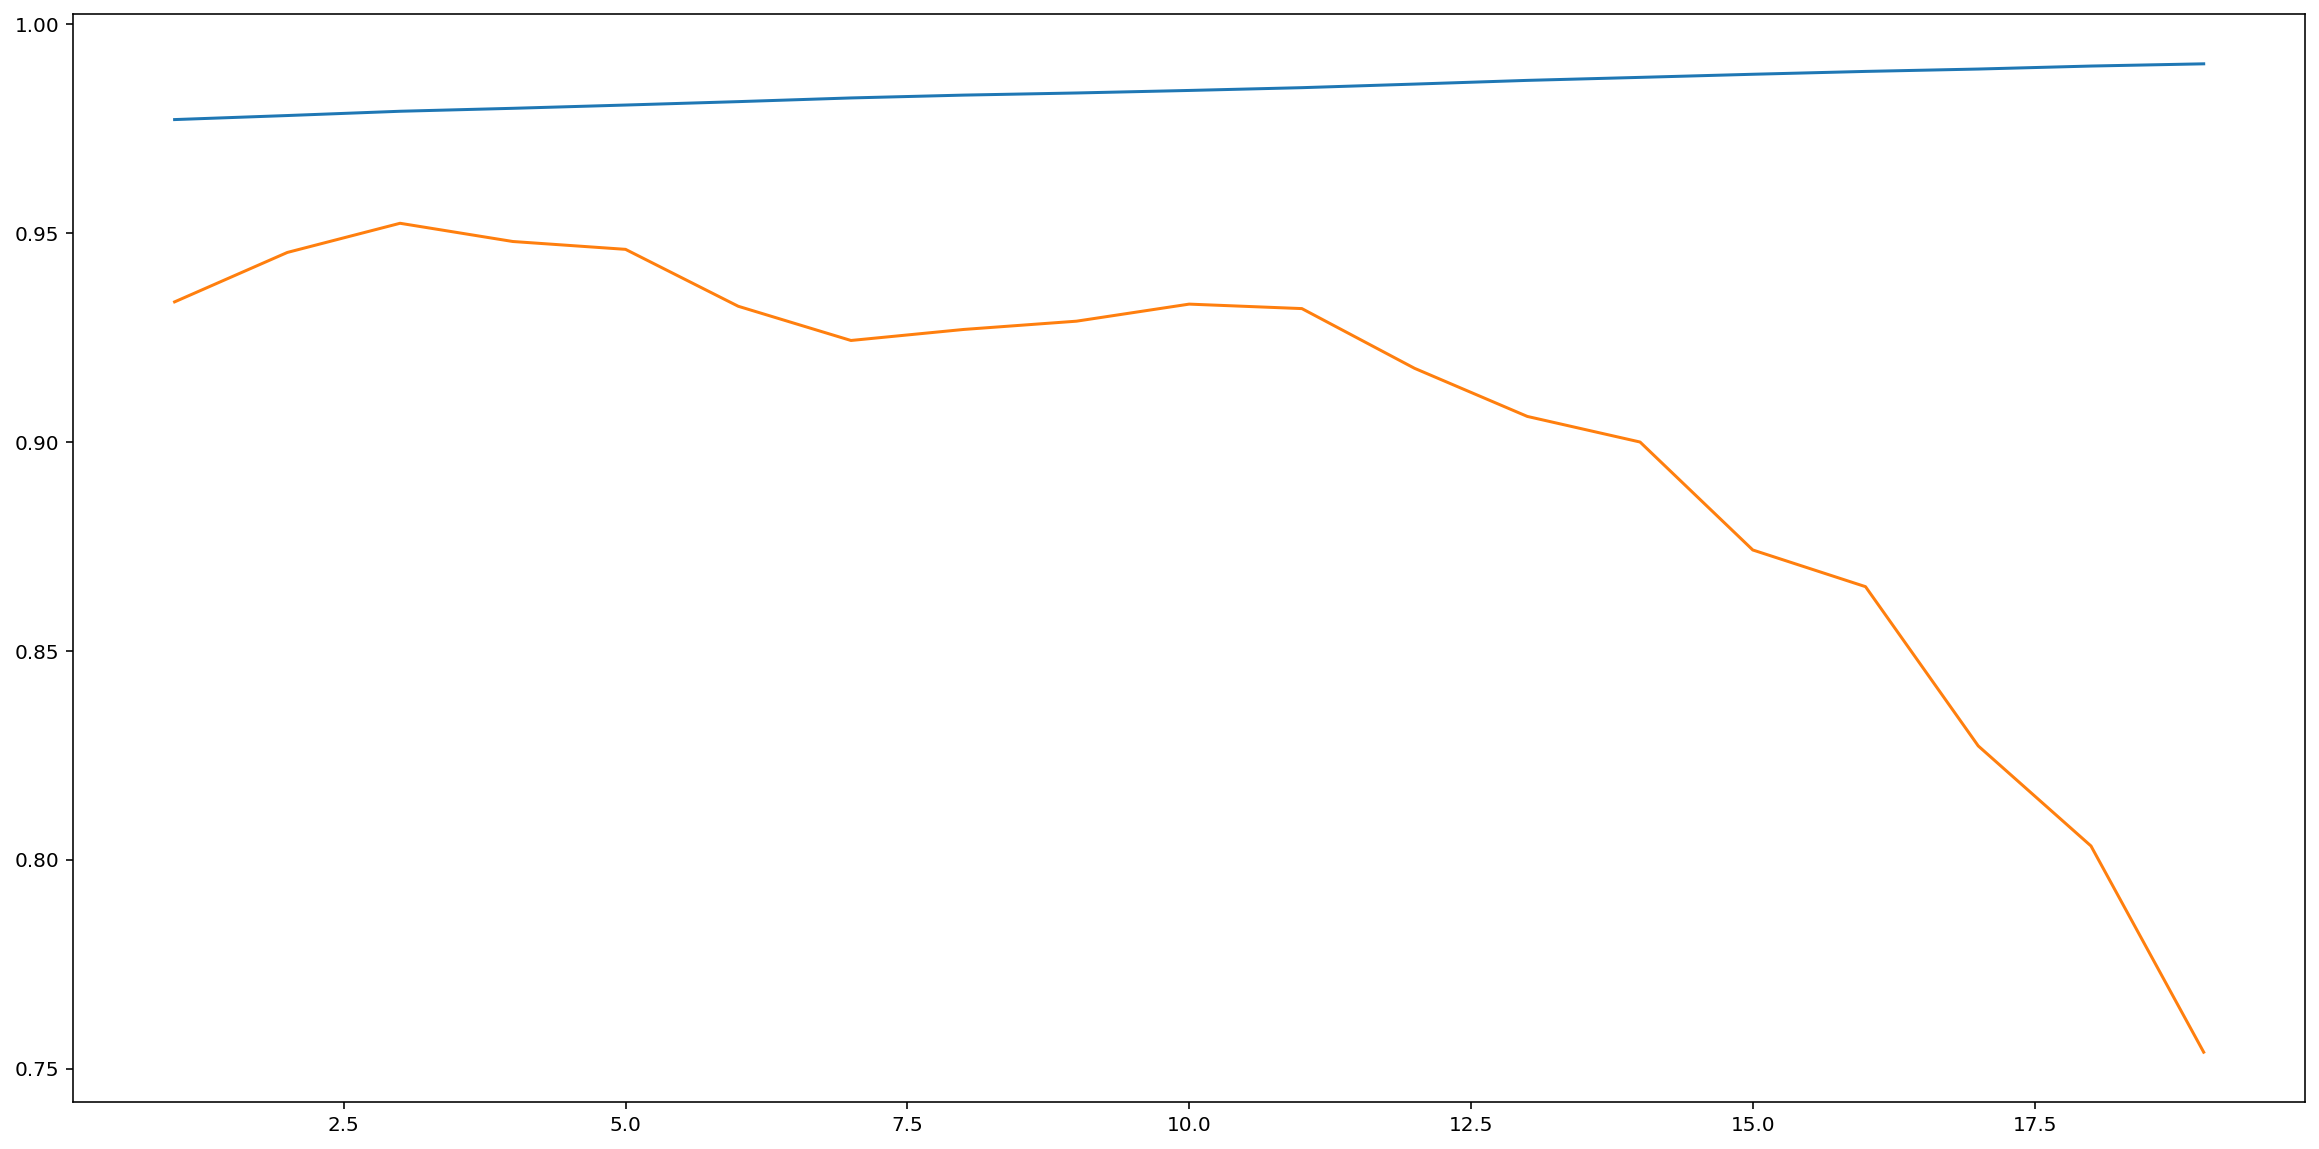

In [16]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(x, y)
plt.show()

In [17]:
y

array([[0.97716726, 0.93354653],
       [0.97813435, 0.9453743 ],
       [0.97915722, 0.95235466],
       [0.97986238, 0.94799361],
       [0.98064458, 0.94611652],
       [0.98146126, 0.93249708],
       [0.98234405, 0.92431031],
       [0.98302238, 0.9269487 ],
       [0.98353111, 0.92892481],
       [0.9841372 , 0.93300953],
       [0.98480152, 0.93193956],
       [0.98565897, 0.91764519],
       [0.98654625, 0.90613696],
       [0.98726505, 0.9000121 ],
       [0.98800903, 0.87418046],
       [0.98869259, 0.86540171],
       [0.98925873, 0.82729745],
       [0.98997704, 0.80335837],
       [0.99050909, 0.75401446]])

In [18]:
x[np.where(y[:, 1] == max(y[:, 1]))][0]

3

In [19]:
n_hours = 3
n_features = scaled.shape[1]
n_predict = 1
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, n_predict)

# split into train and test sets
values = reframed.values
n_train_hours = 500
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
n_obs = n_hours * n_features

train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
  
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

linear_model = LinearRegression()
linear_model.fit(train_X.reshape(train_X.shape[0], train_X.shape[1]*train_X.shape[2]), train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
linear_model.score(test_X.reshape(test_X.shape[0], test_X.shape[1]*test_X.shape[2]), test_y)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.9523546633017155

In [0]:
y_hat = scaler.inverse_transform(test_y)
y_pred = scaler.inverse_transform(linear_model.predict(test_X.reshape(test_X.shape[0], test_X.shape[1]*test_X.shape[2])))

In [0]:
res = []
i = 0
n = 10

while len(res) < len(test_y):
  temp_res = test_X[i]
  for j in range(n):
    temp_res = np.concatenate((temp_res, linear_model.predict(temp_res[-n_hours:].reshape(1, n_features * n_hours))))
    res.append(temp_res[-1])
  i = i + n

y_pred = np.array(res)[:len(test_y)]
y_hat = scaler.inverse_transform(test_y)
y_pred = scaler.inverse_transform(y_pred)

In [34]:
for i in range(n_features):
    fig, ax = plt.subplots(figsize=(20,10))
    plt.title(new_data.columns[i])
    pd.DataFrame(y_hat[:, i],columns=['TRUE']).plot(ax = ax)
    pd.DataFrame(y_pred[:, i],columns=['PRED']).plot(ax = ax)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [0]:
from statsmodels.tsa.stattools import acf, pacf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


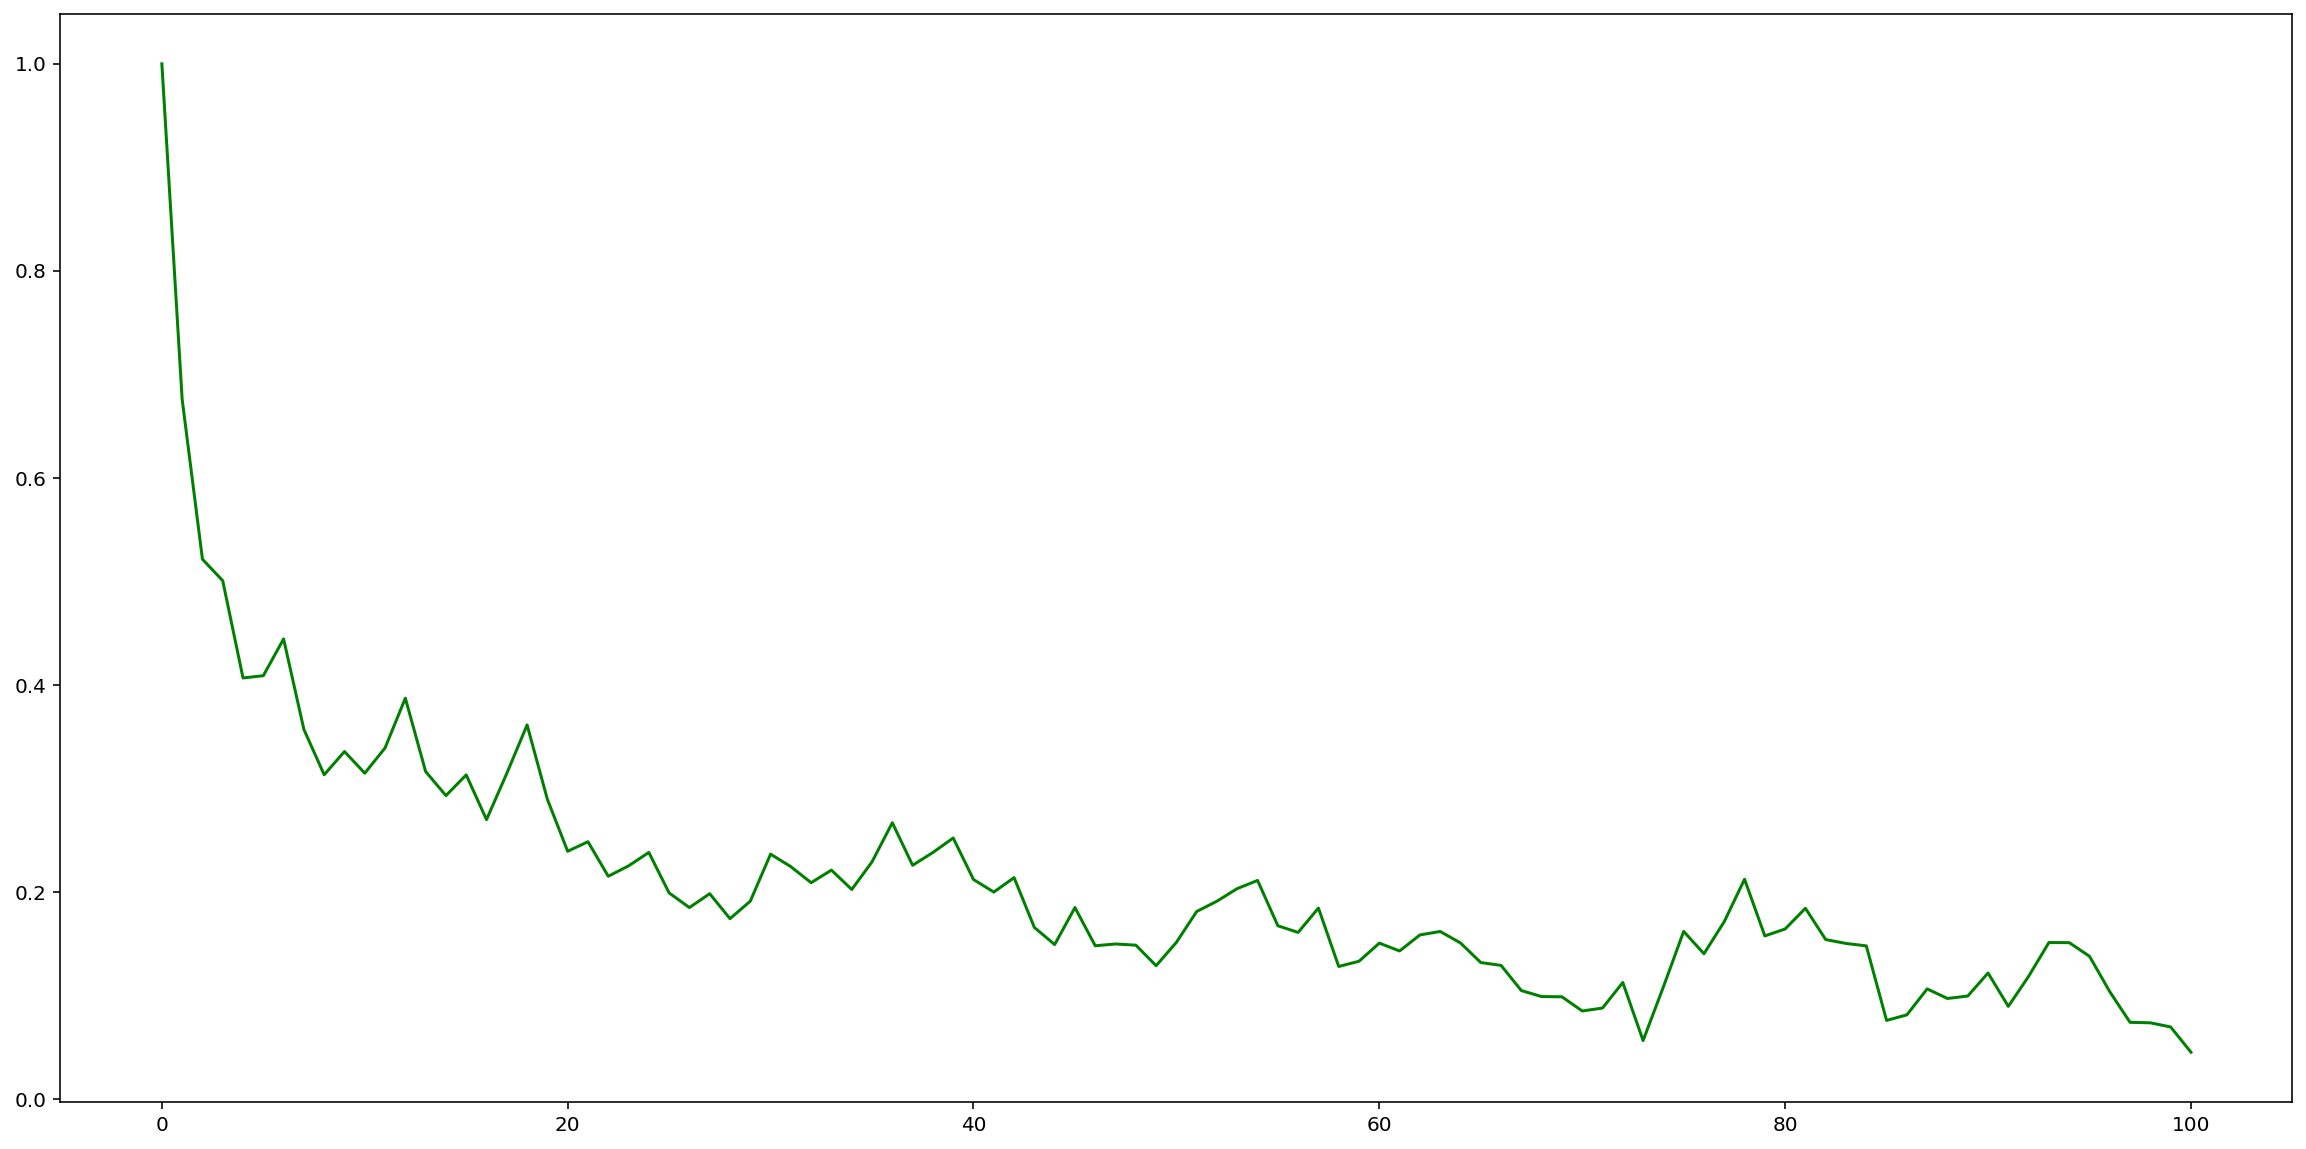

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


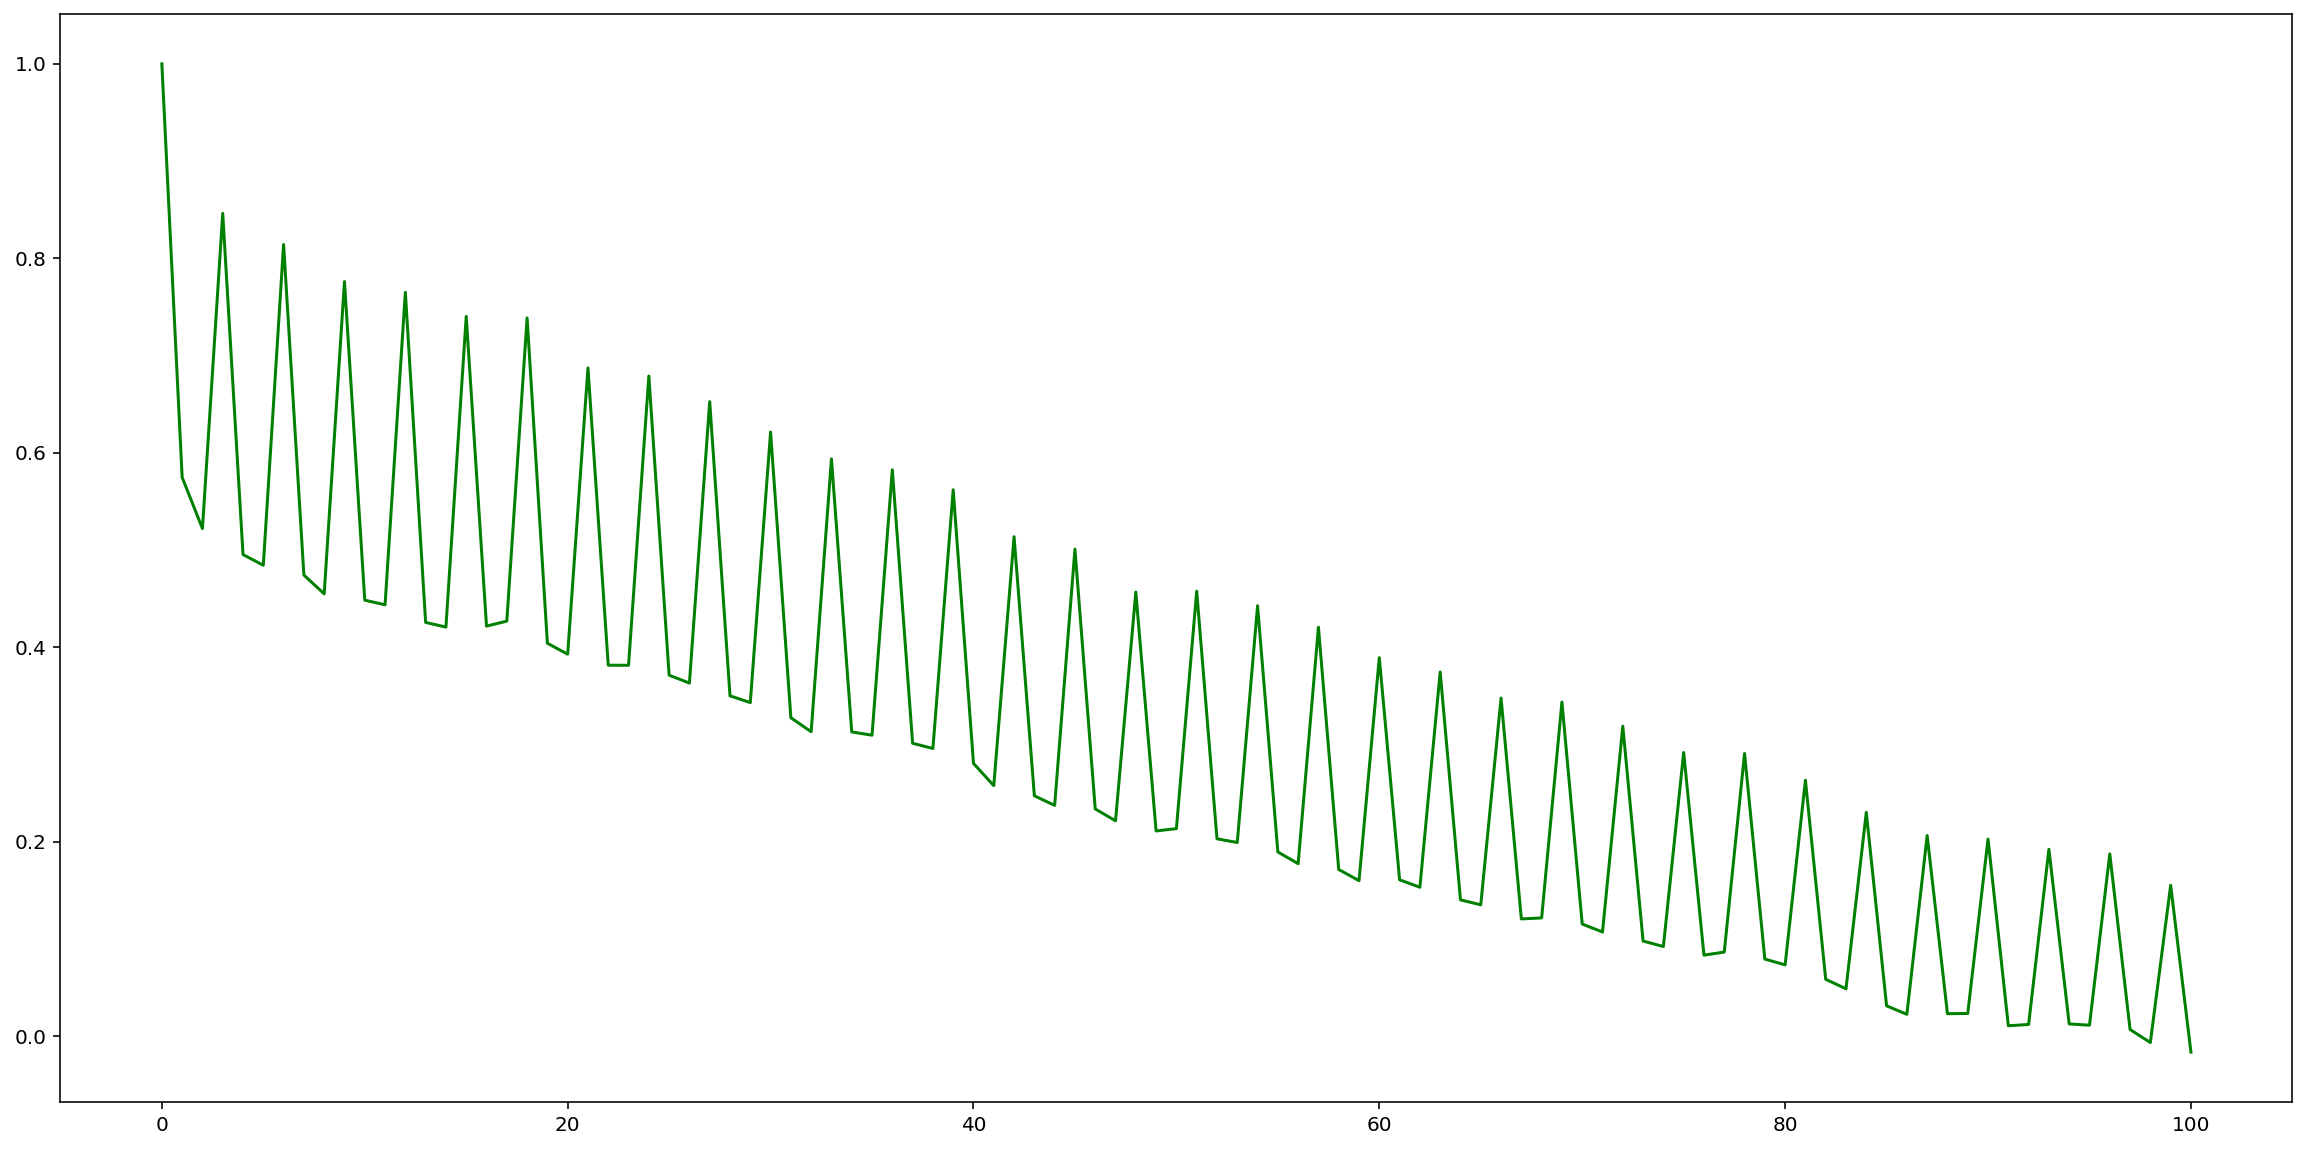

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


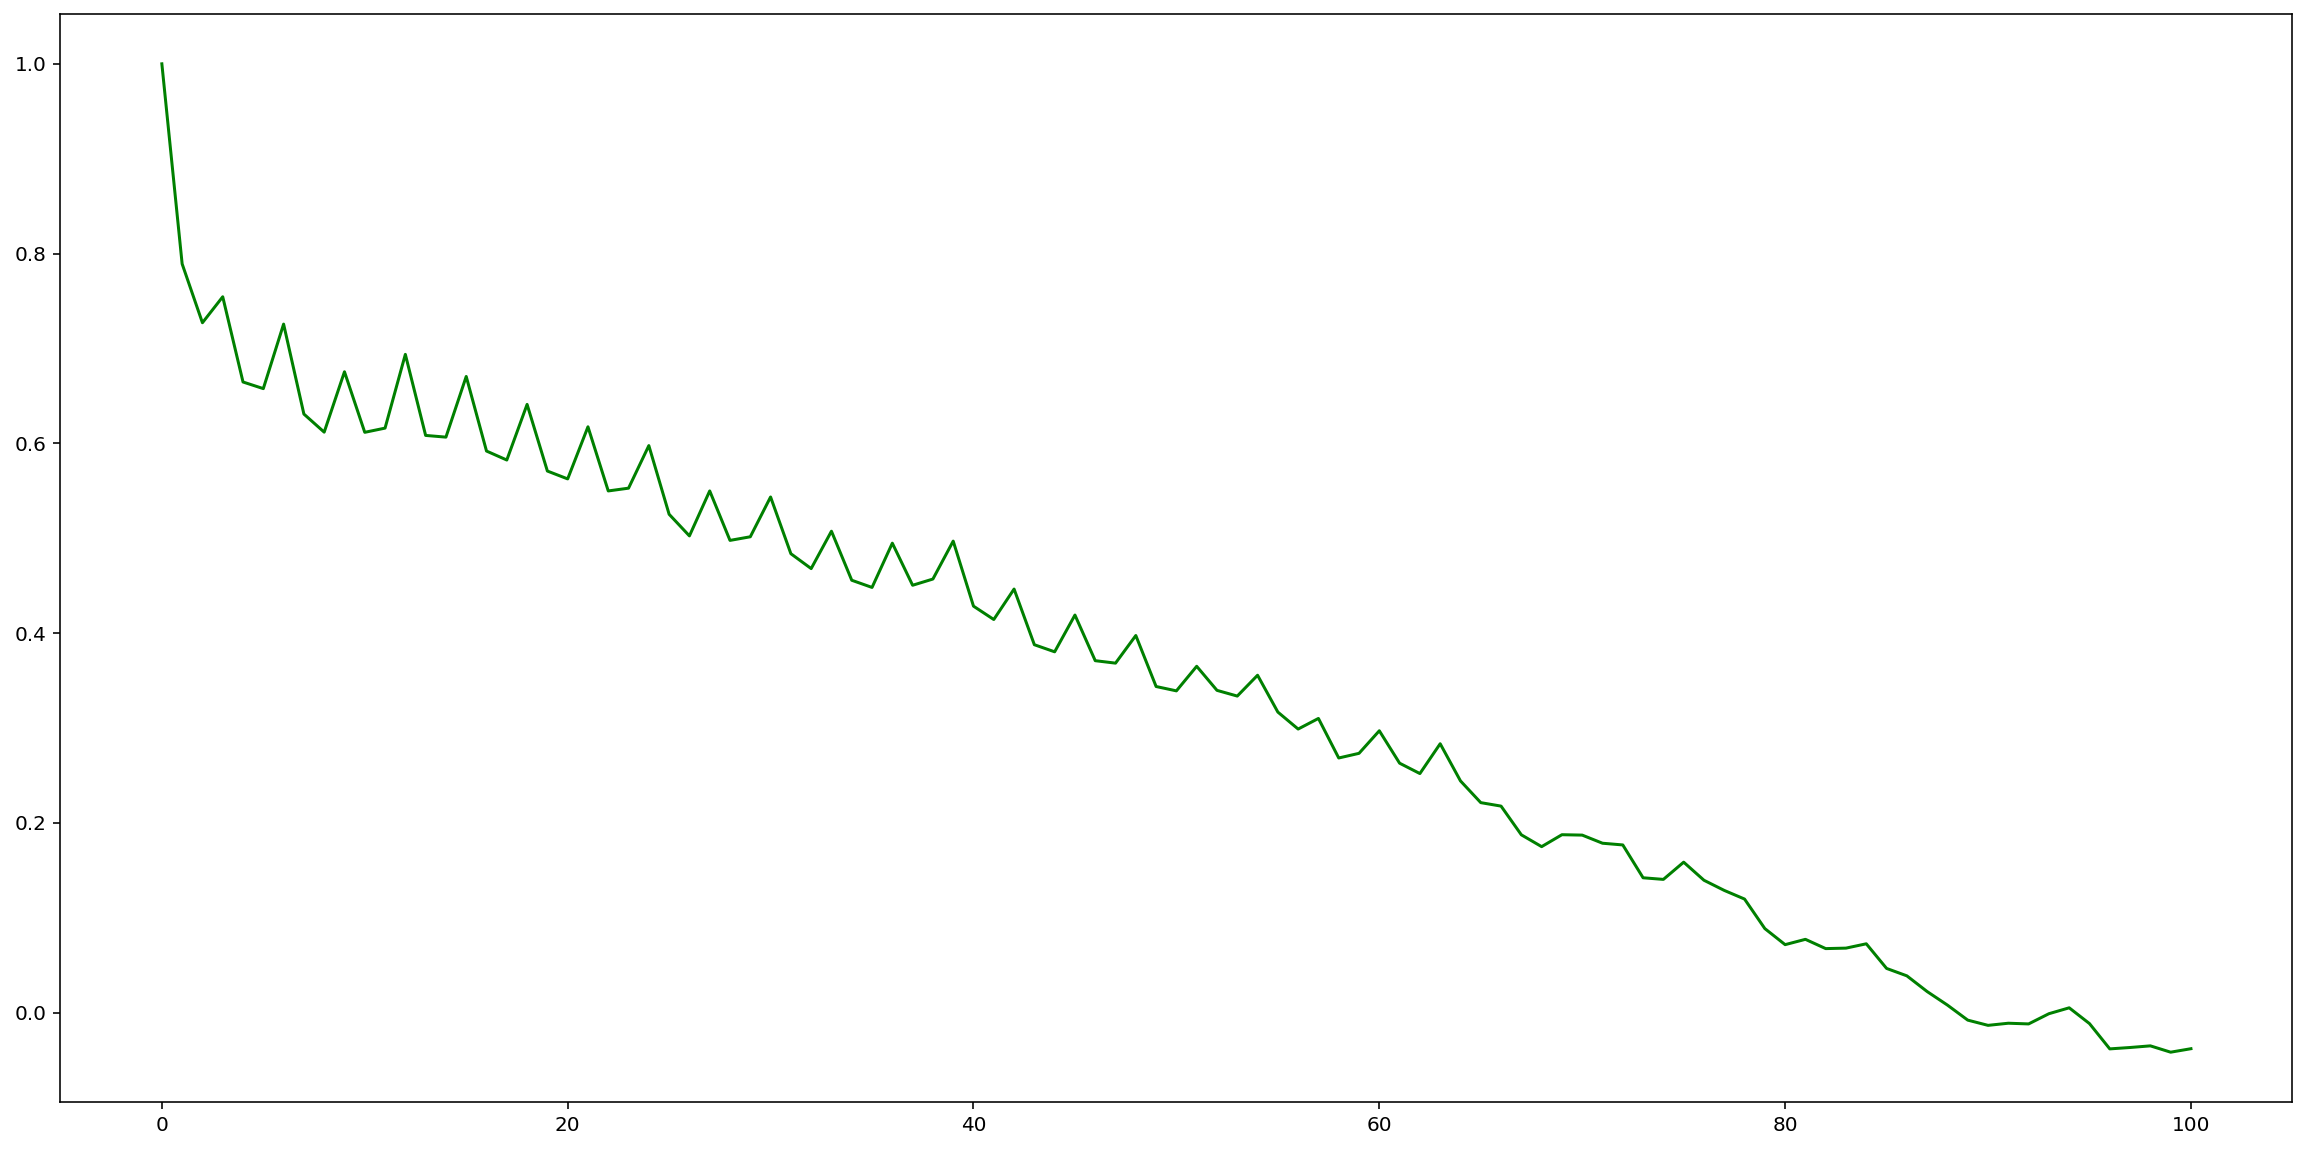

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


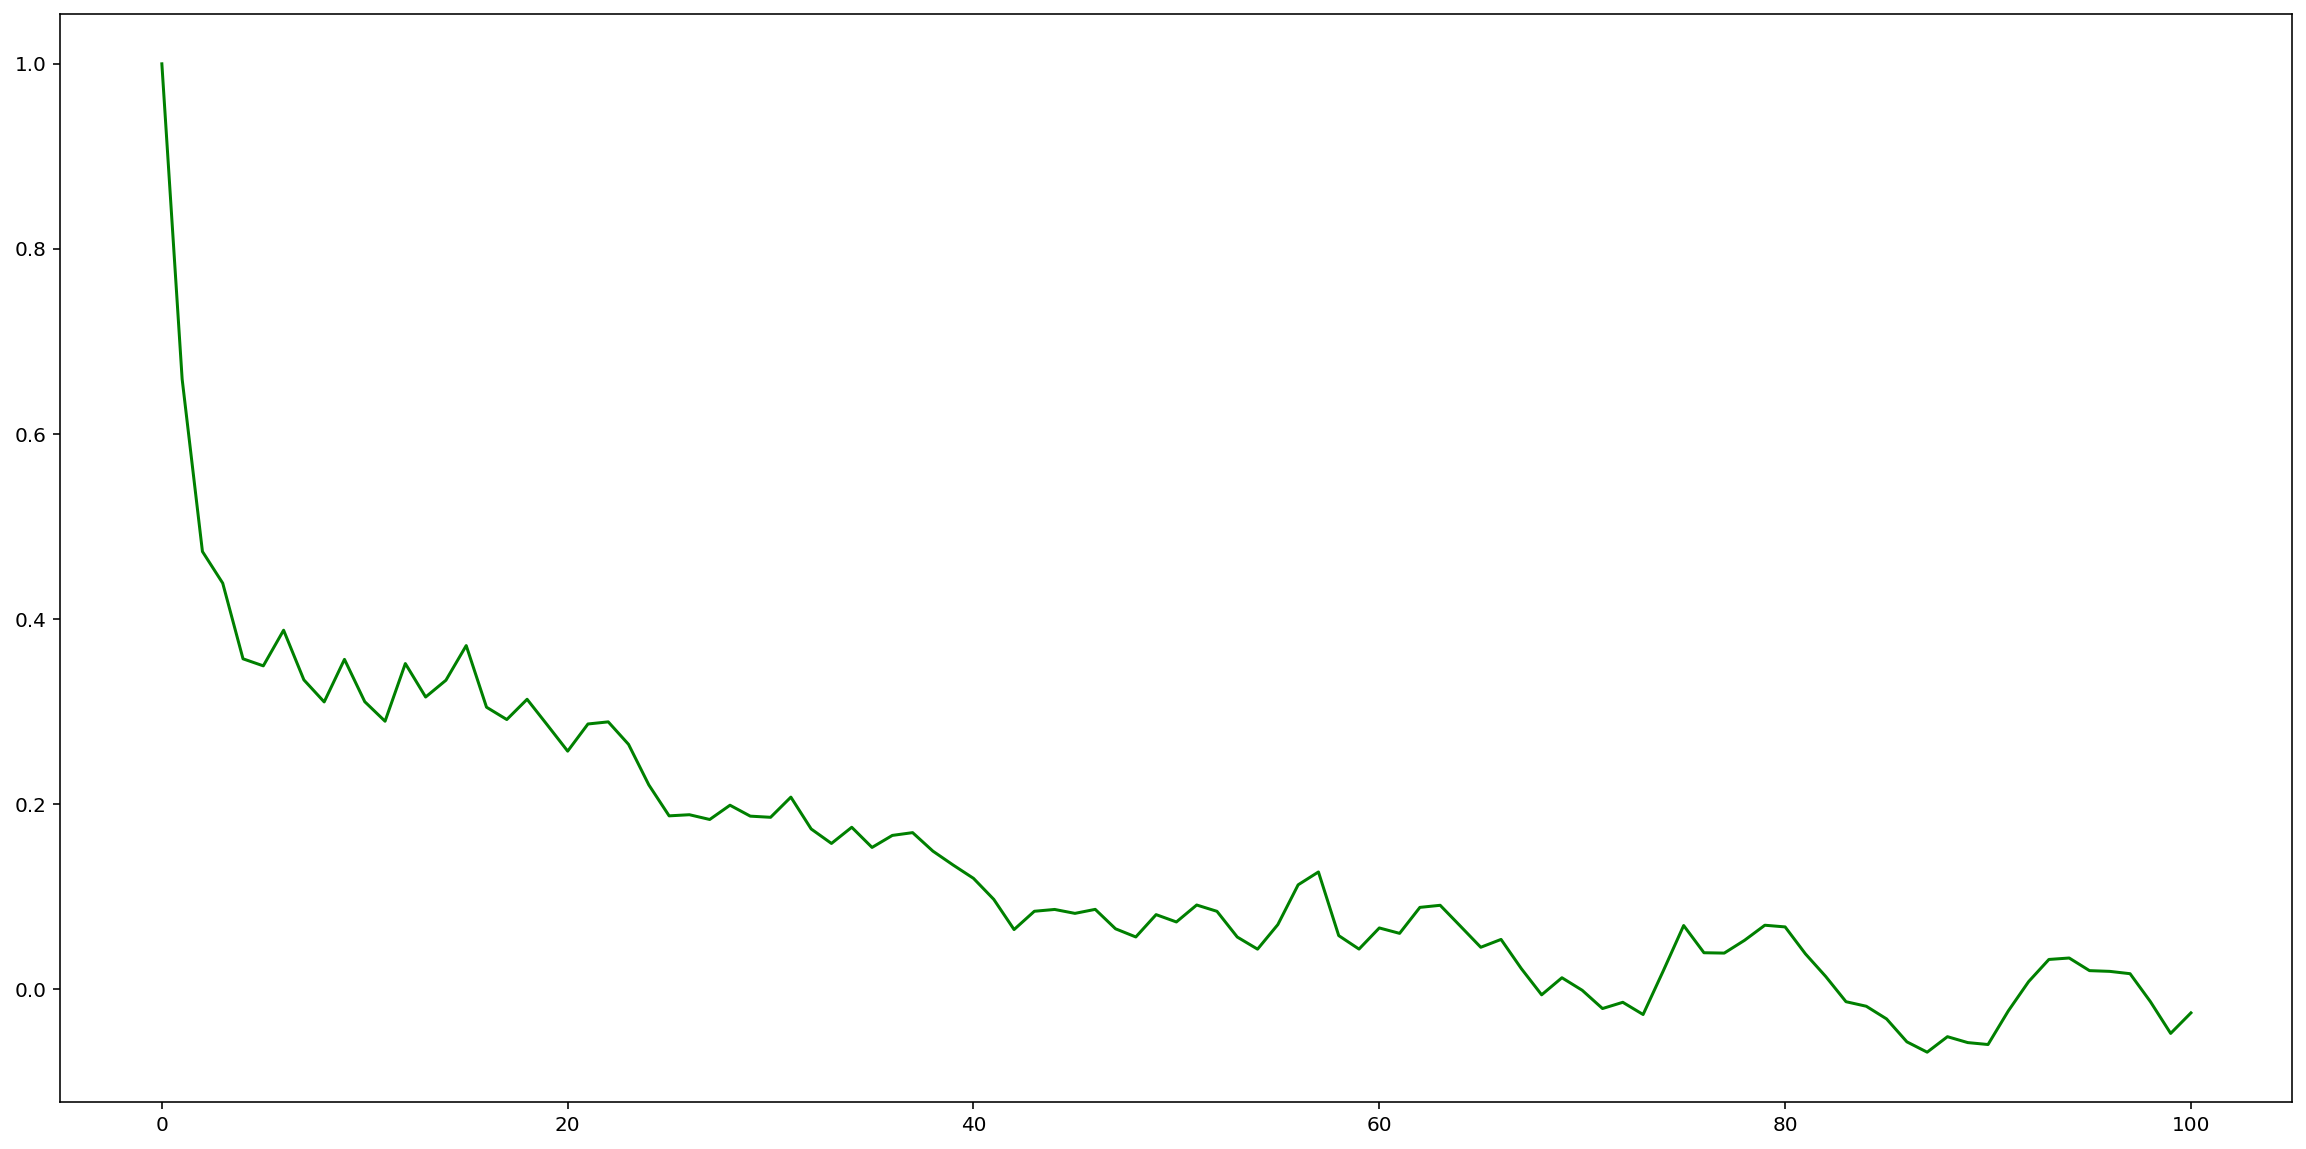

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


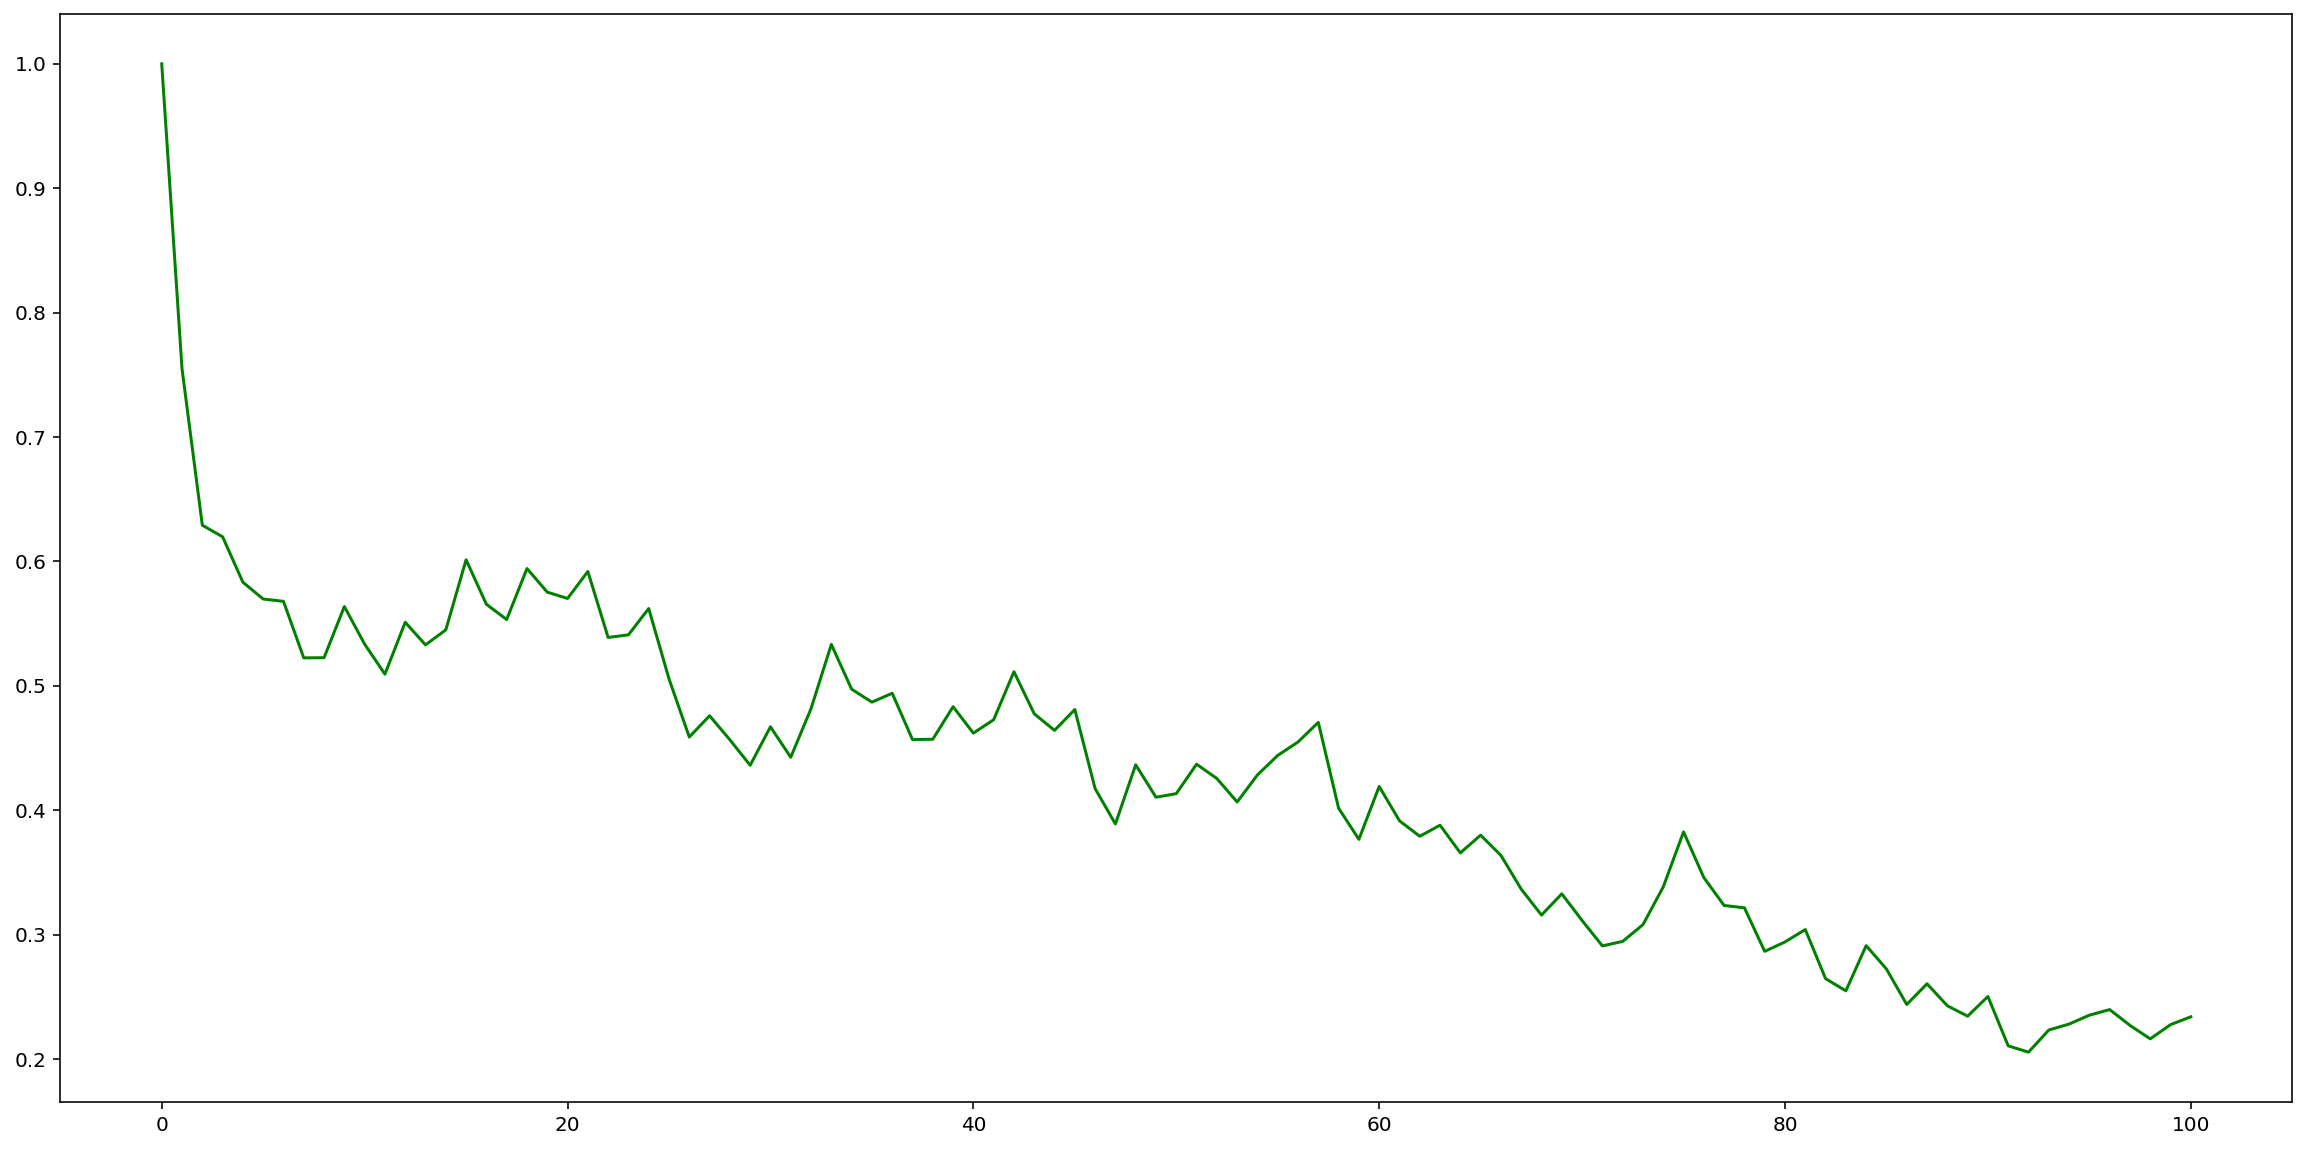

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


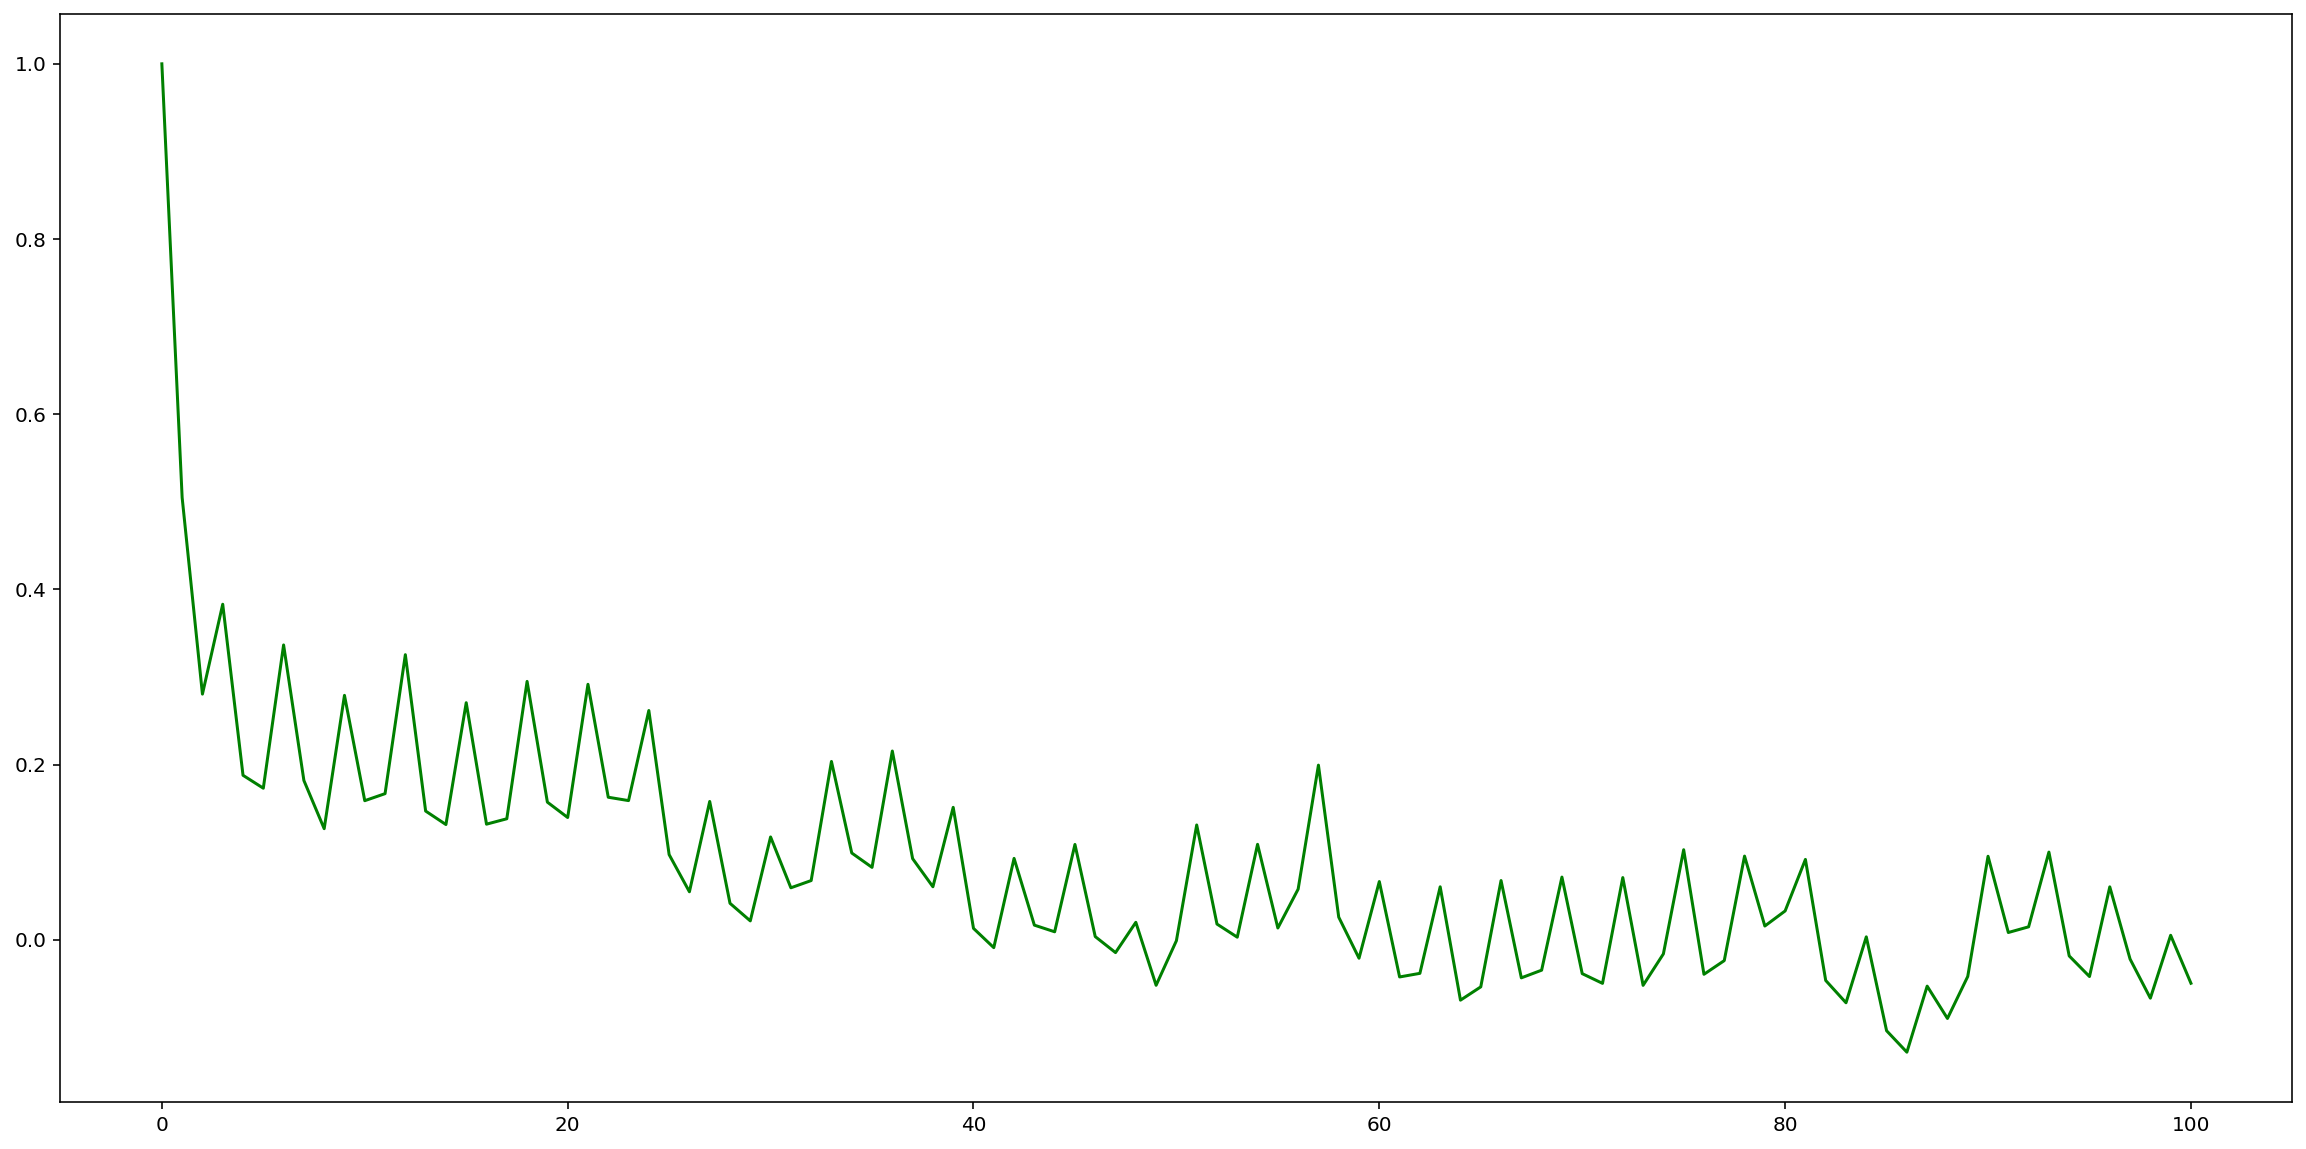

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


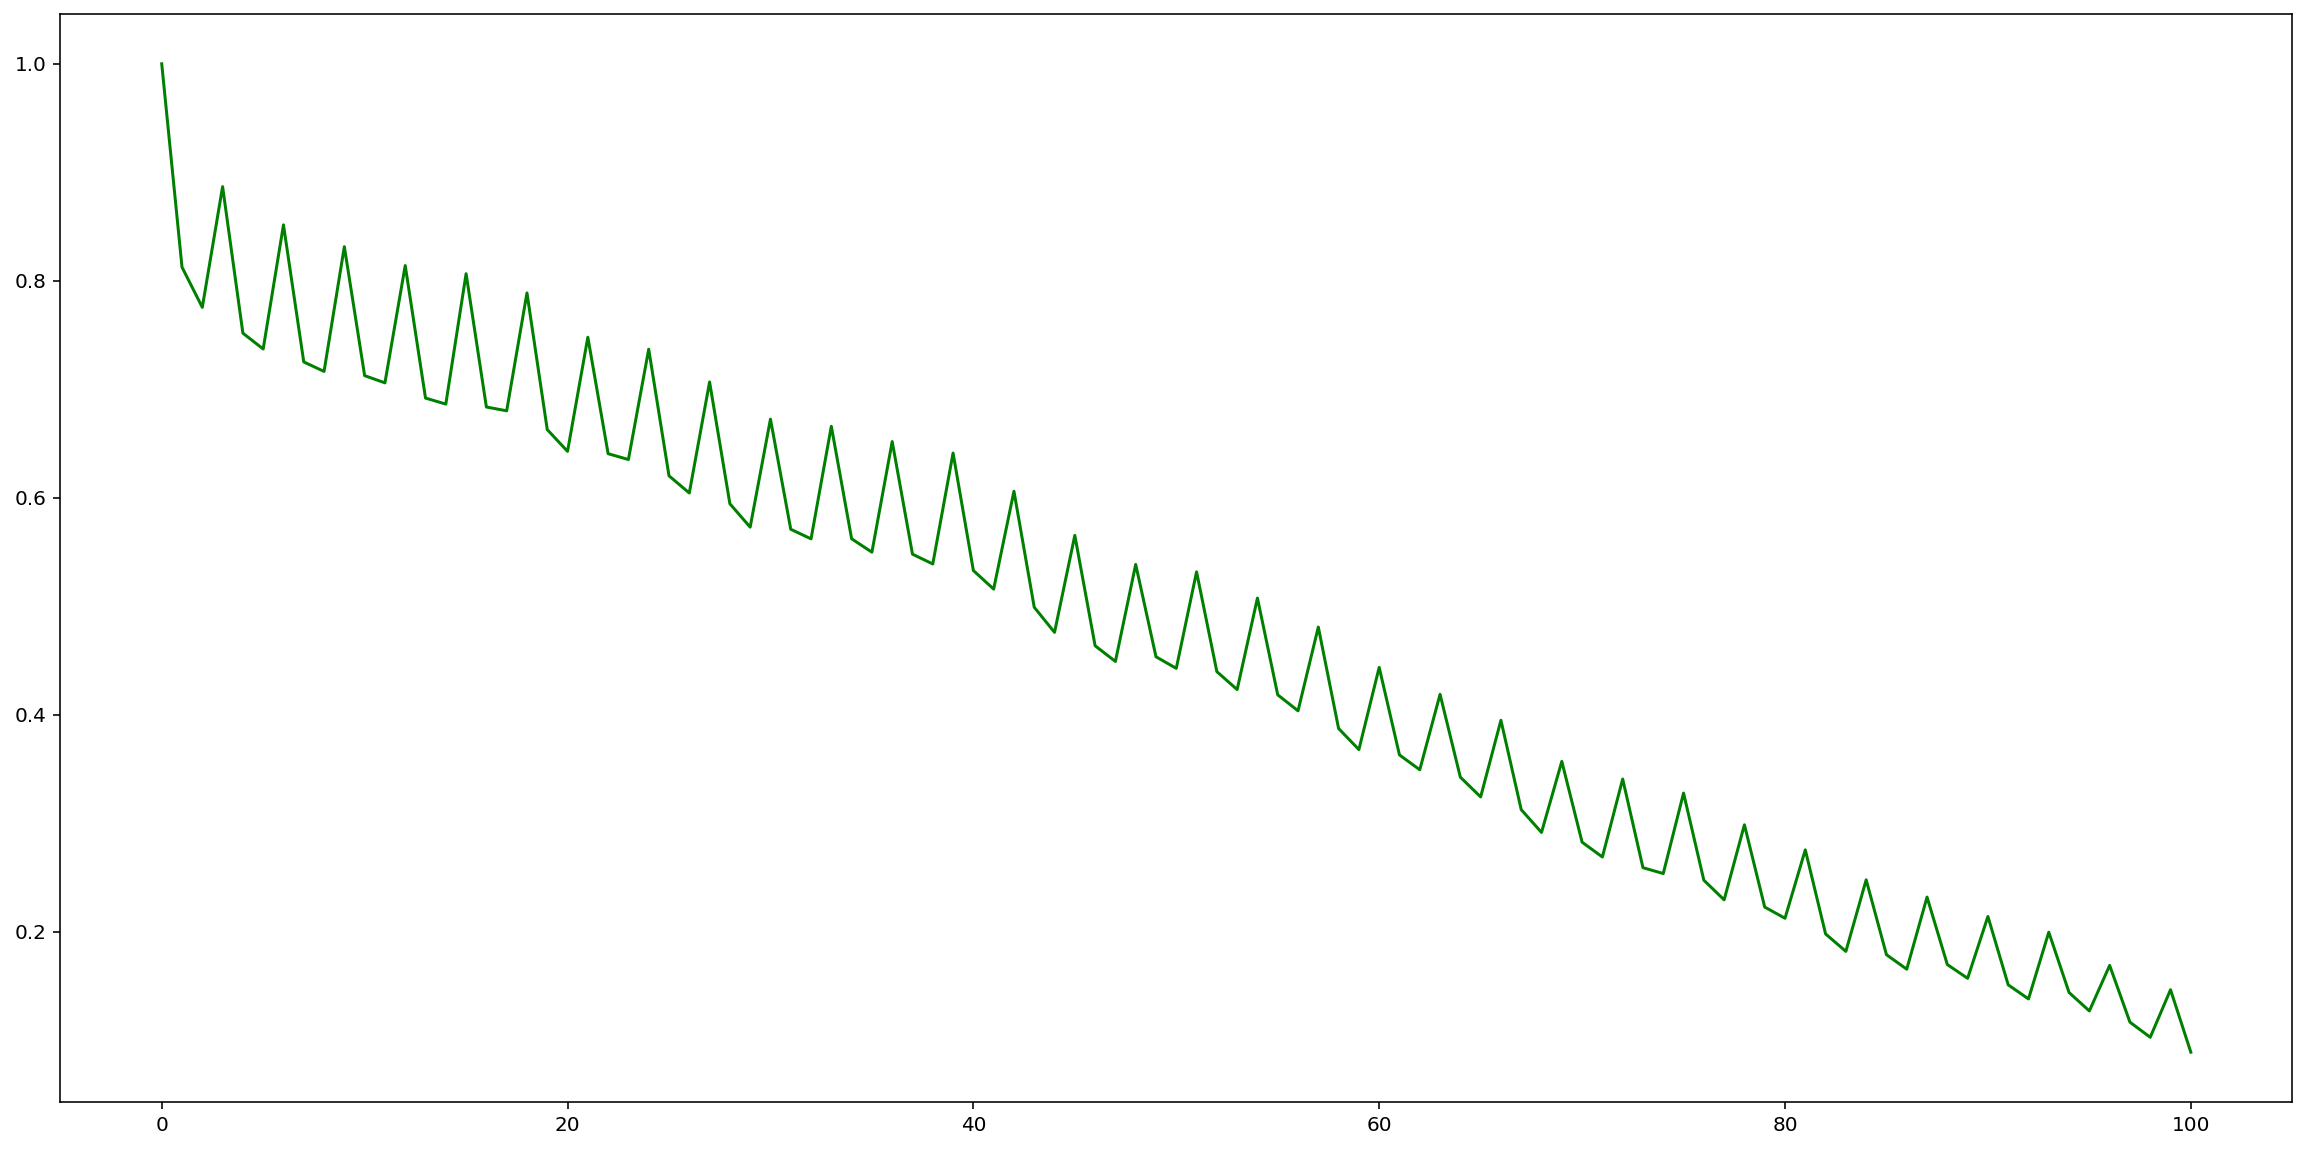

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


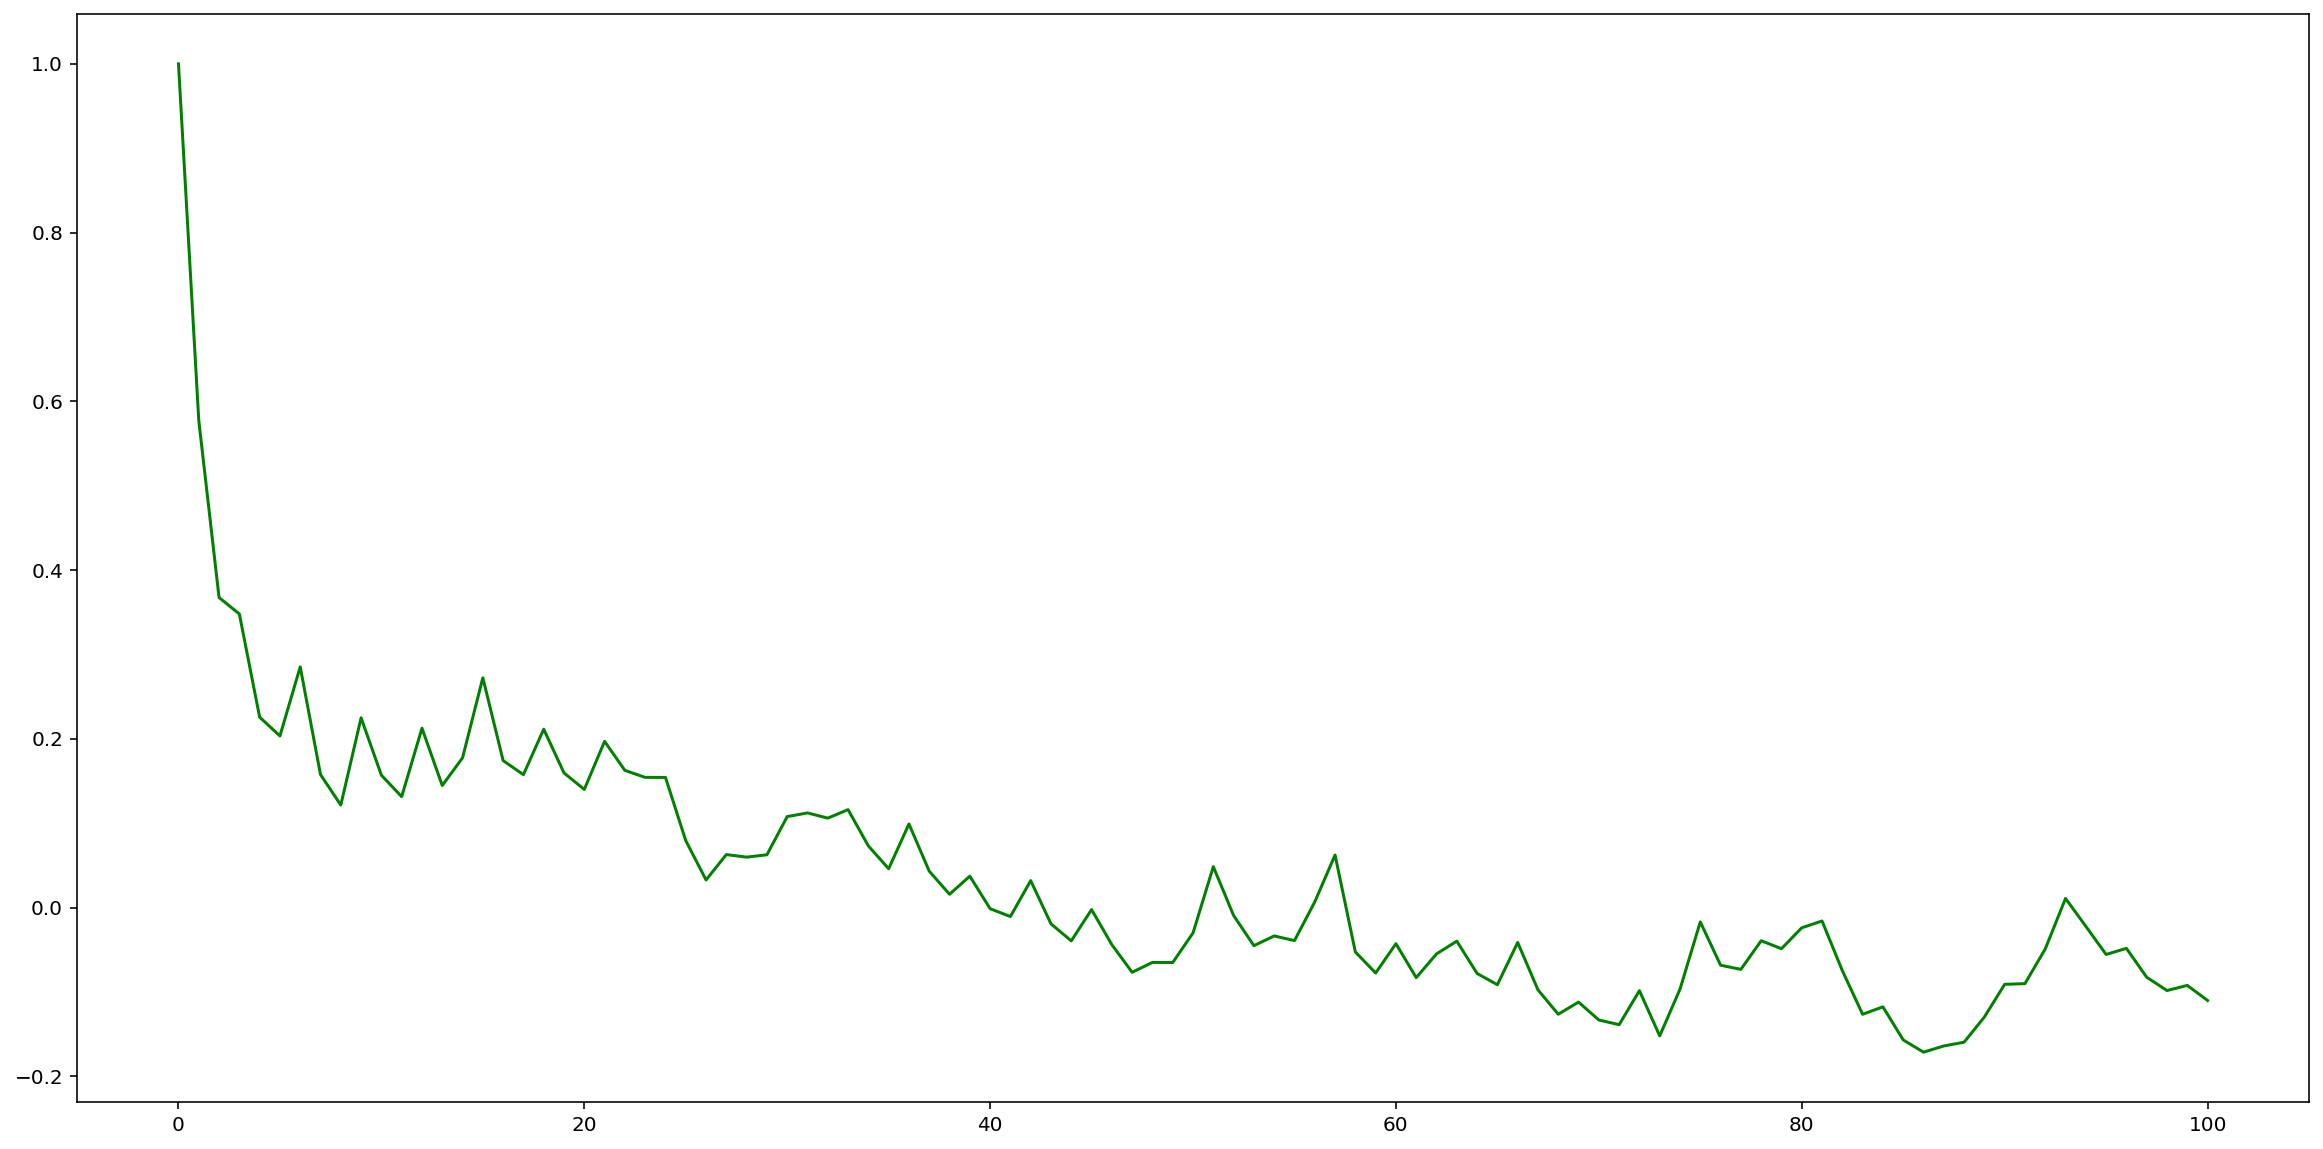

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


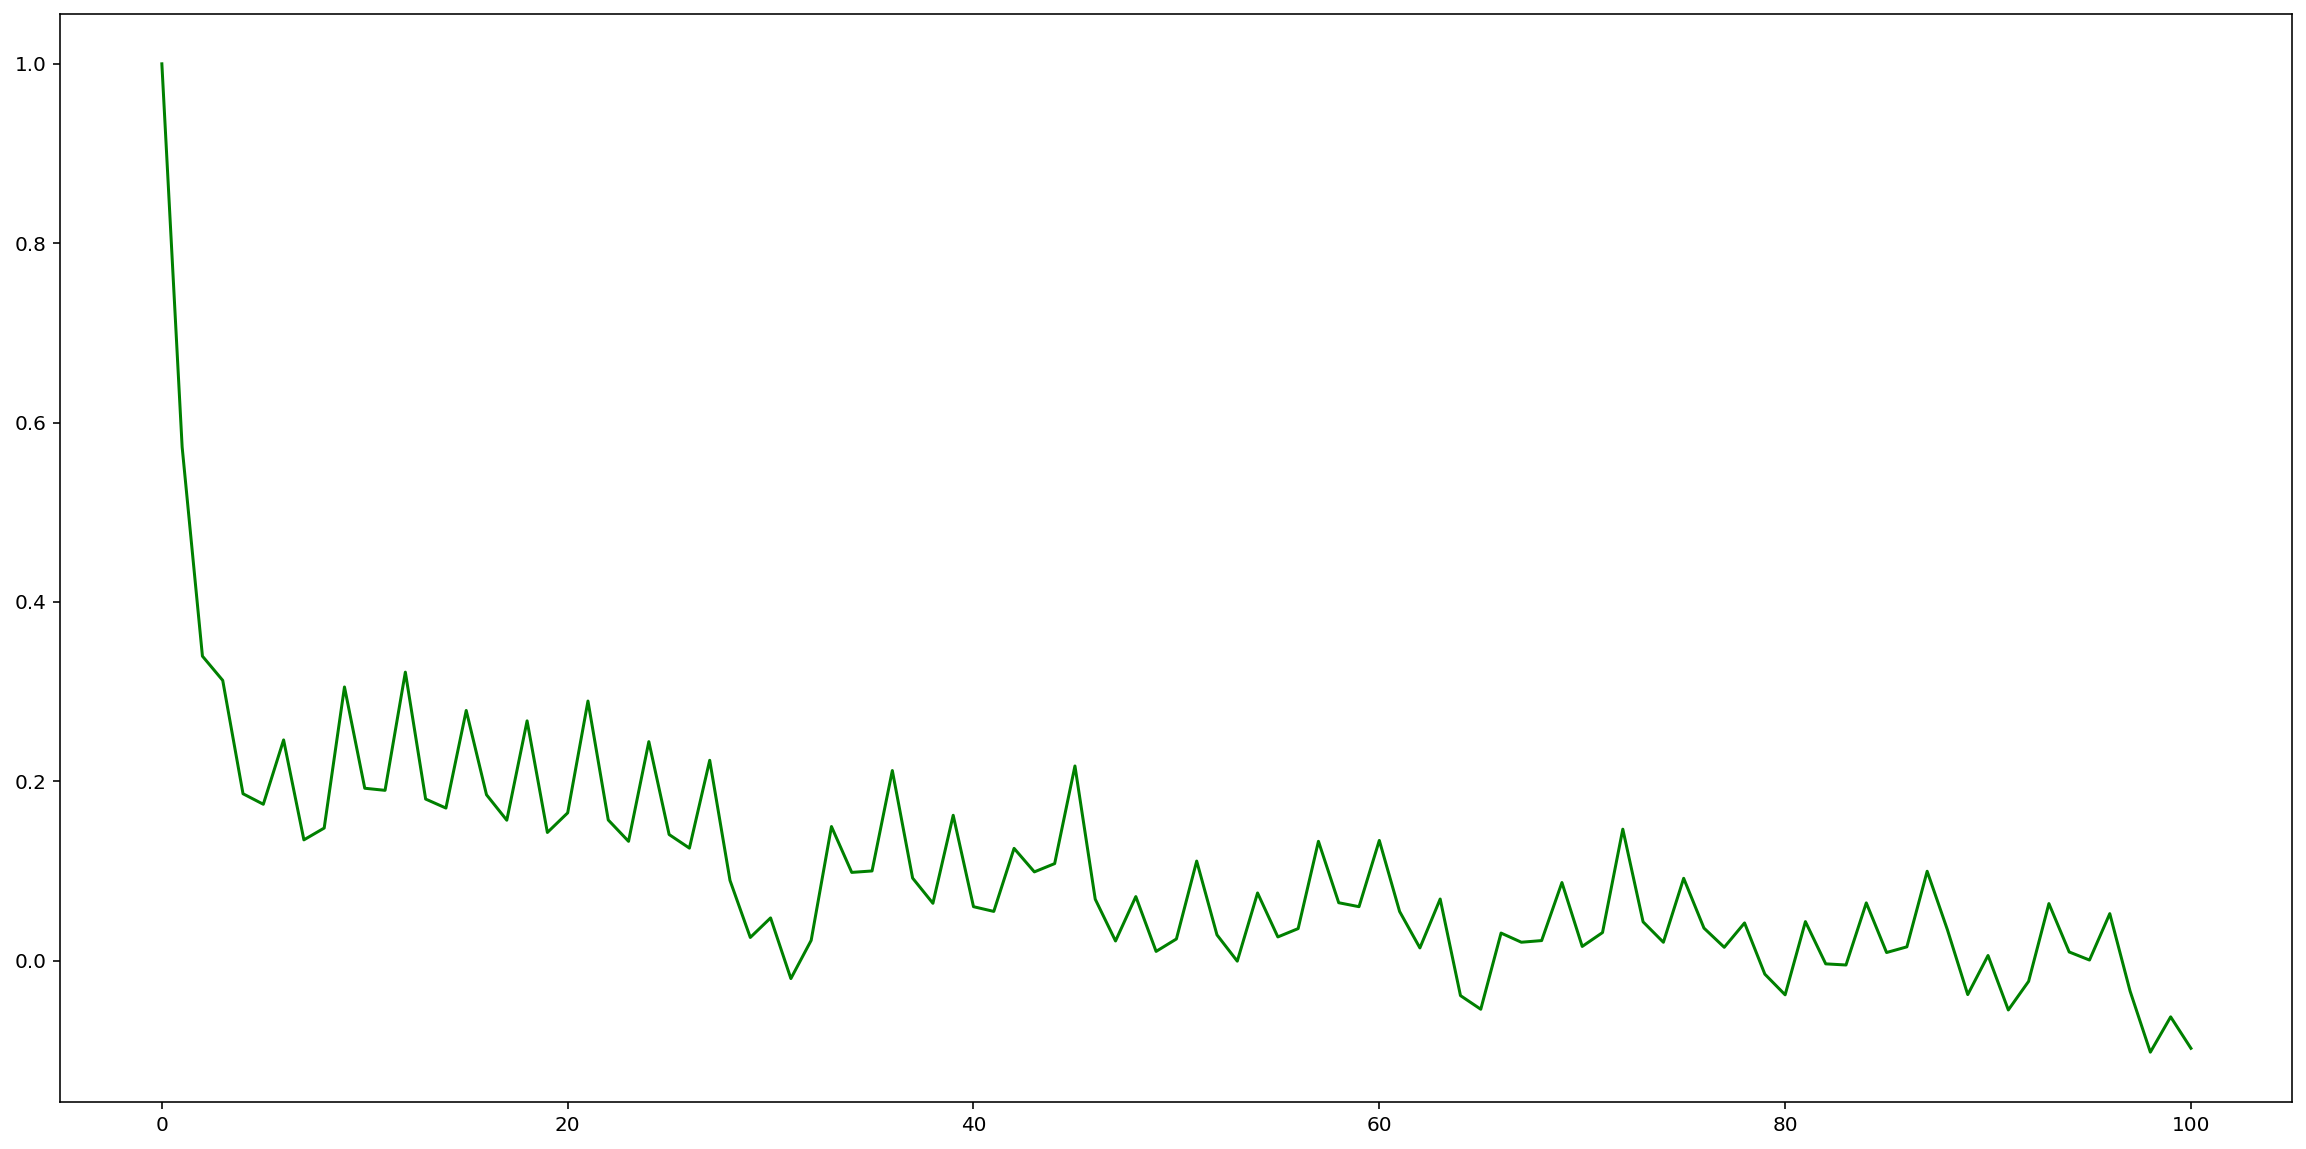

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


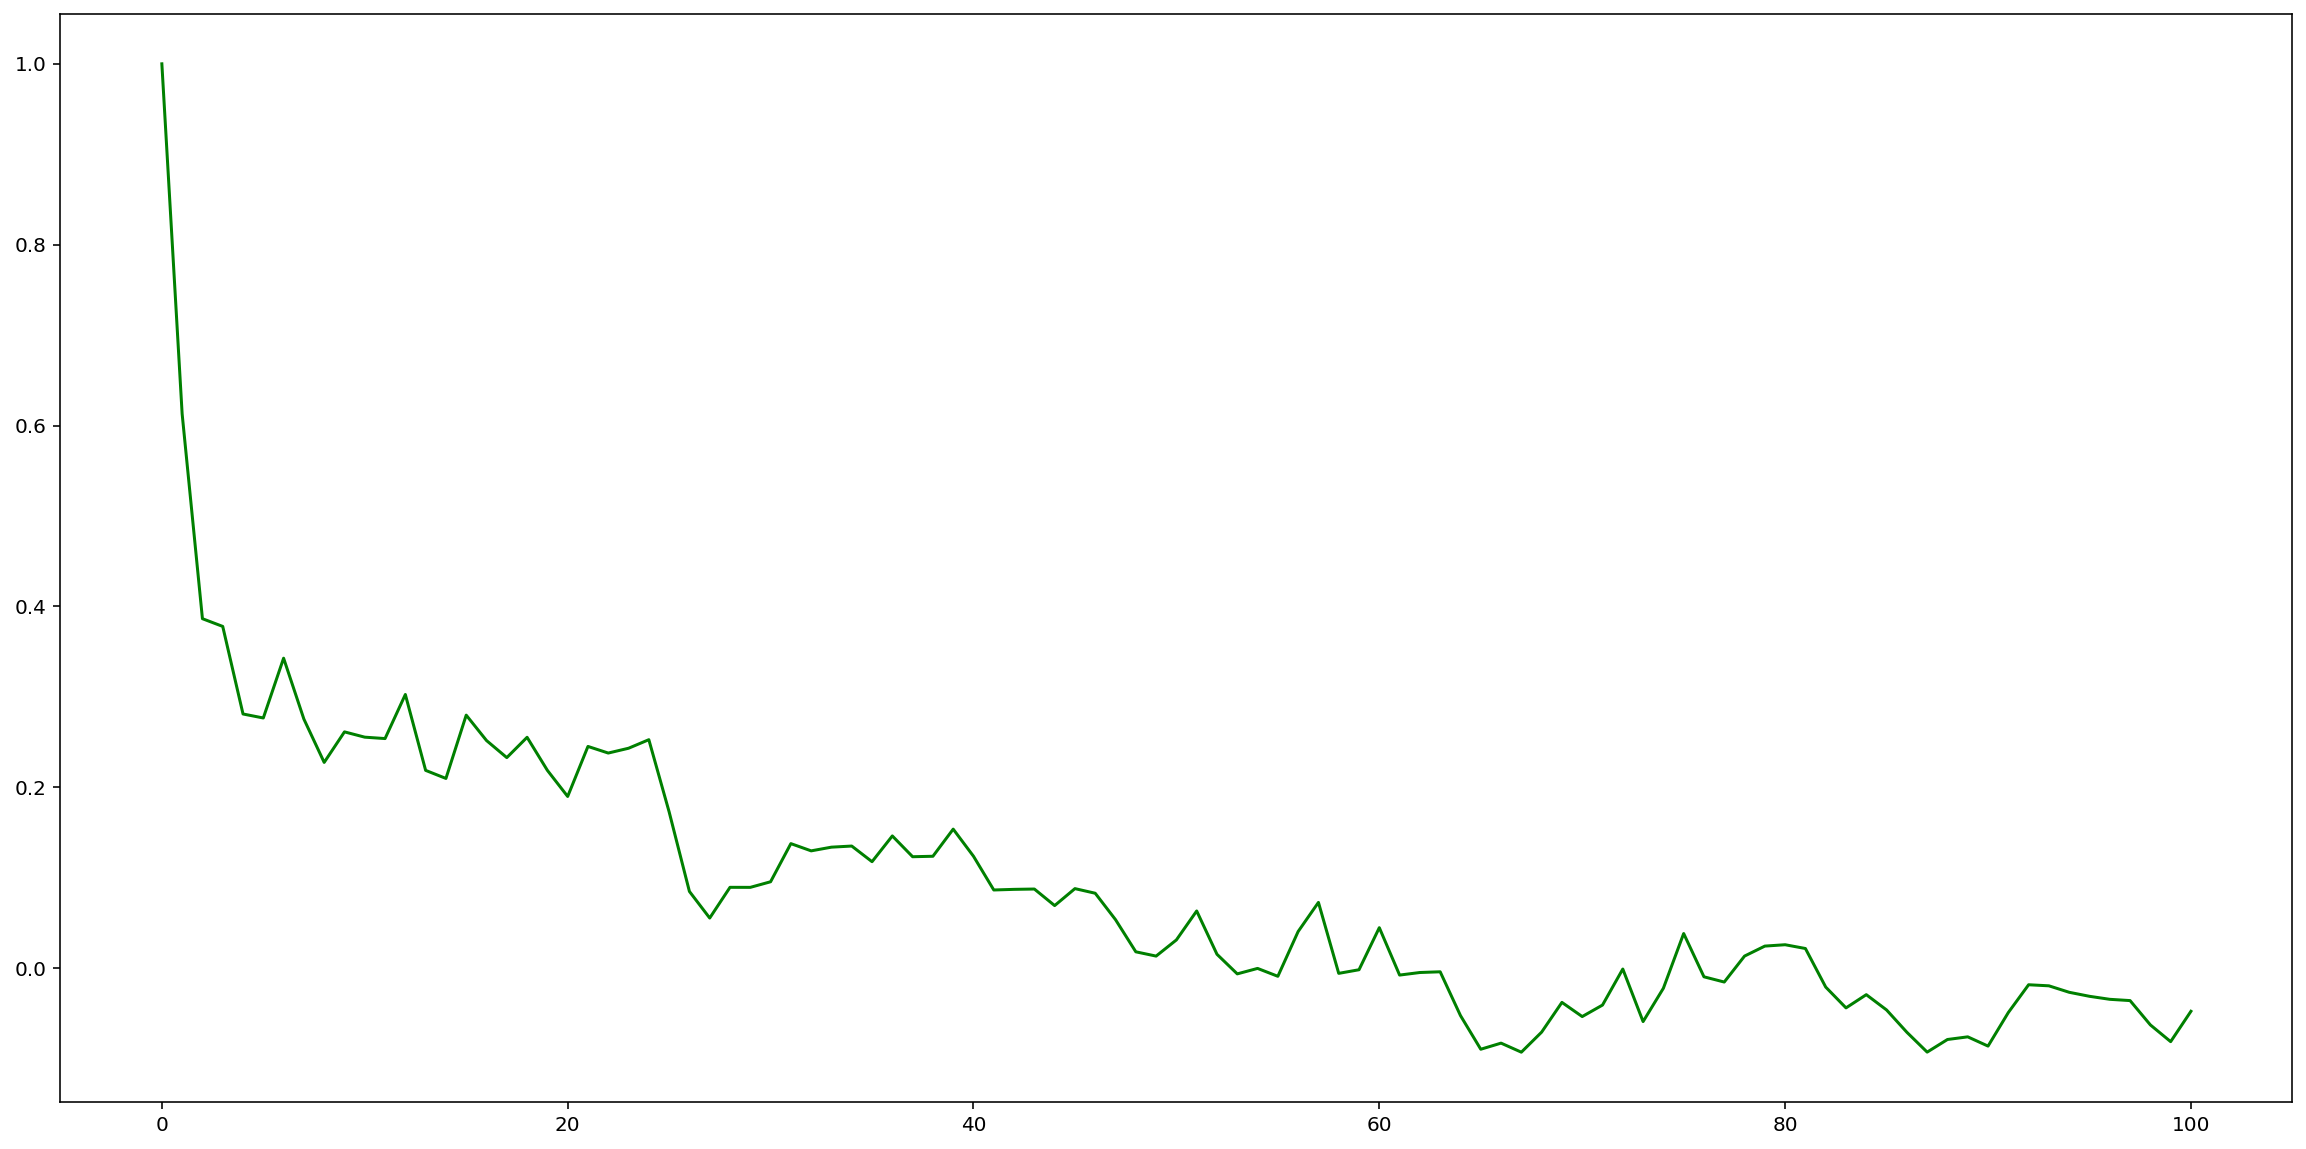

In [0]:
for i in range(n_features):
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(acf(y_pred[:,i] - y_hat[:, i], nlags=100), color='green')
    plt.show()

In [0]:
from statsmodels.graphics.tsaplots import plot_acf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


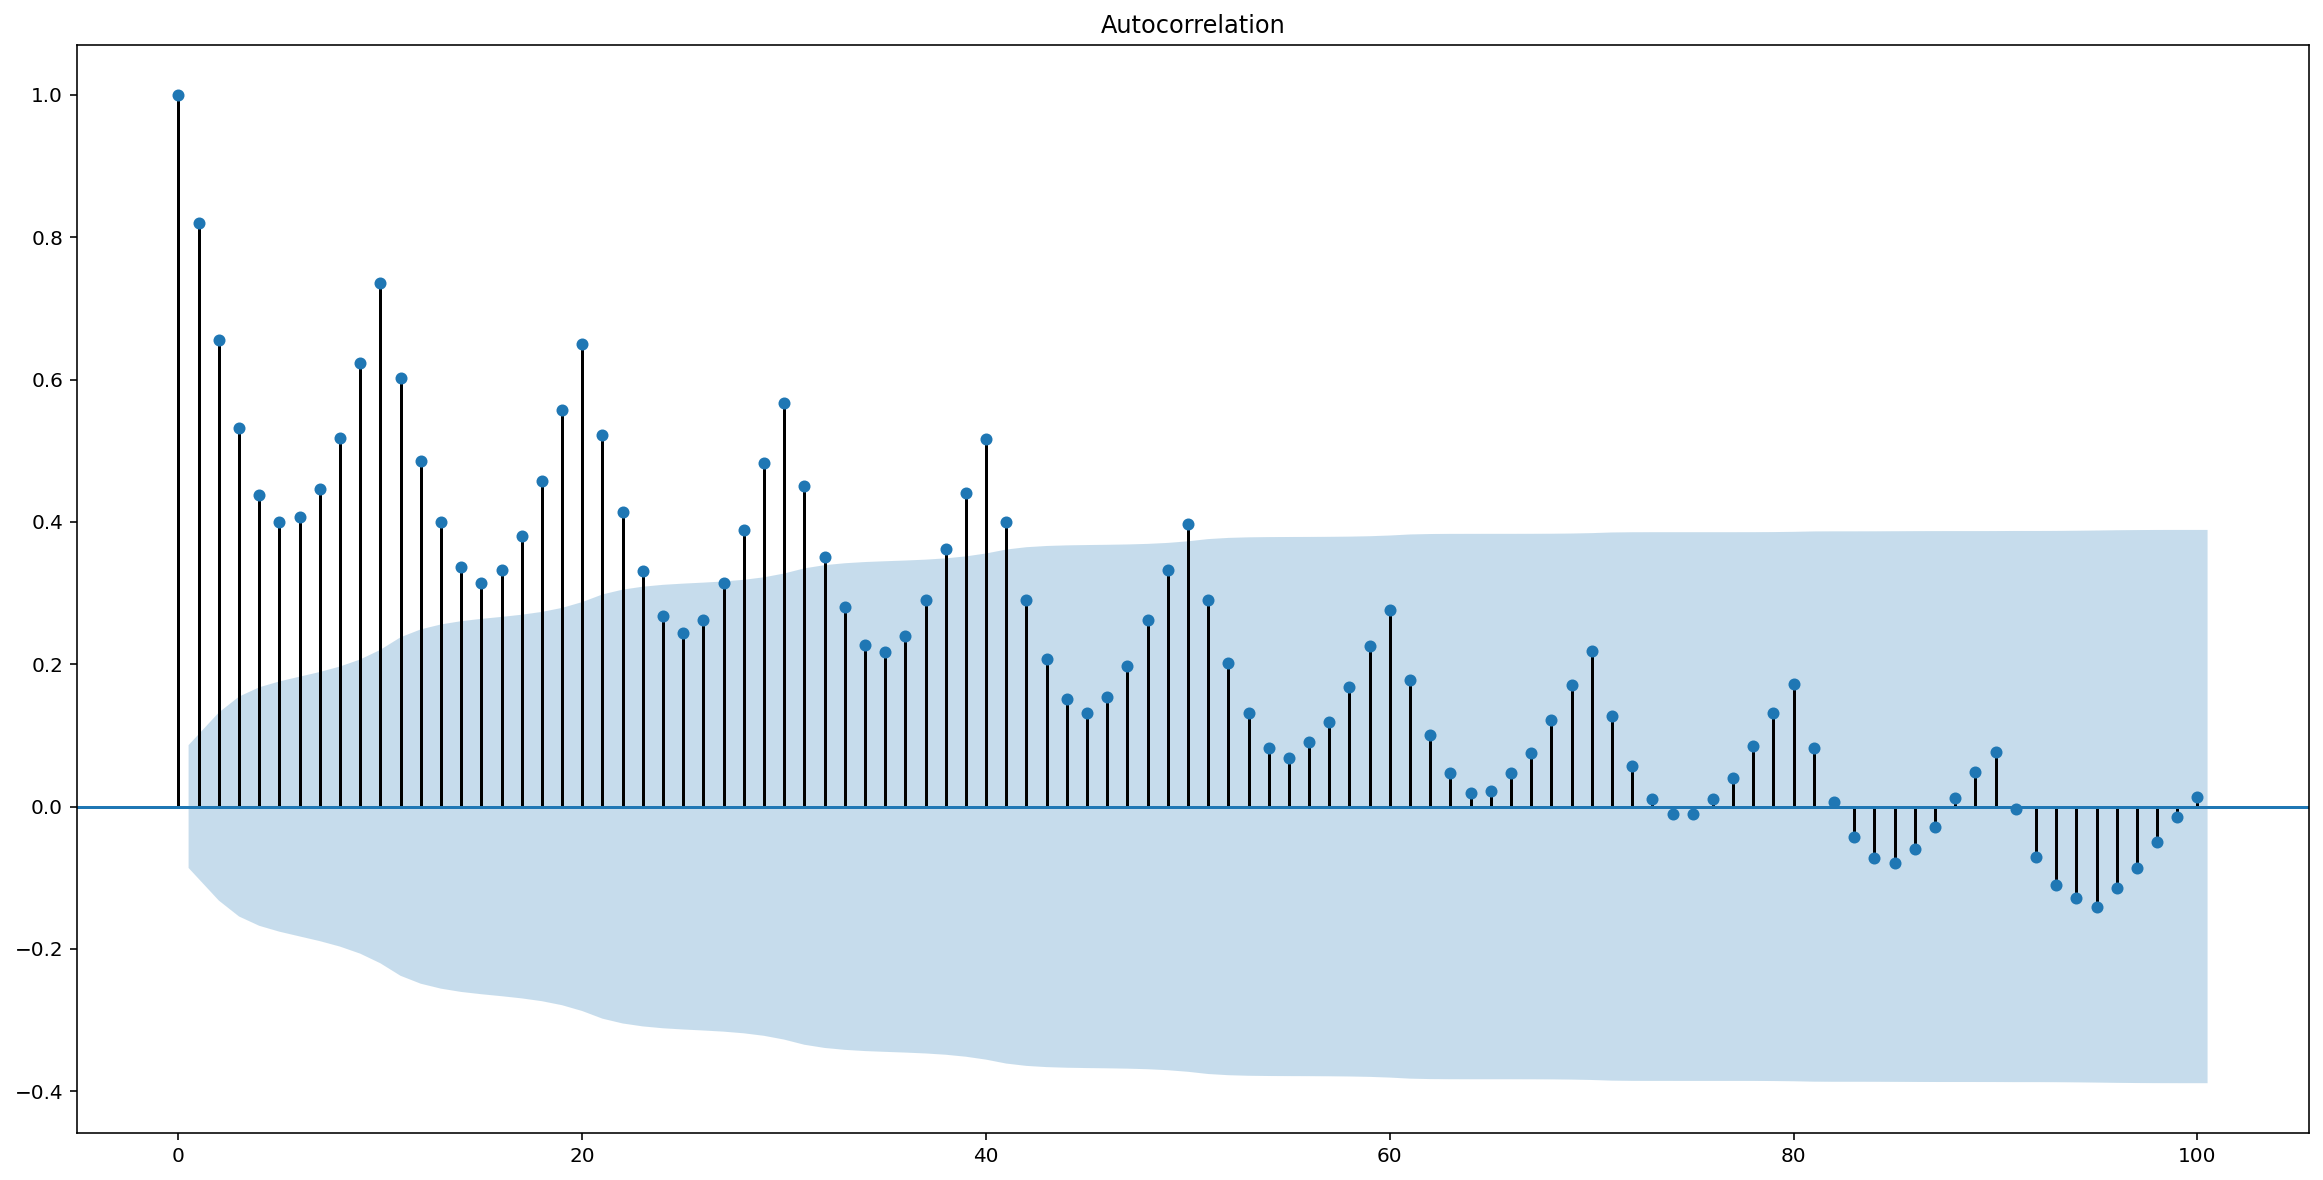

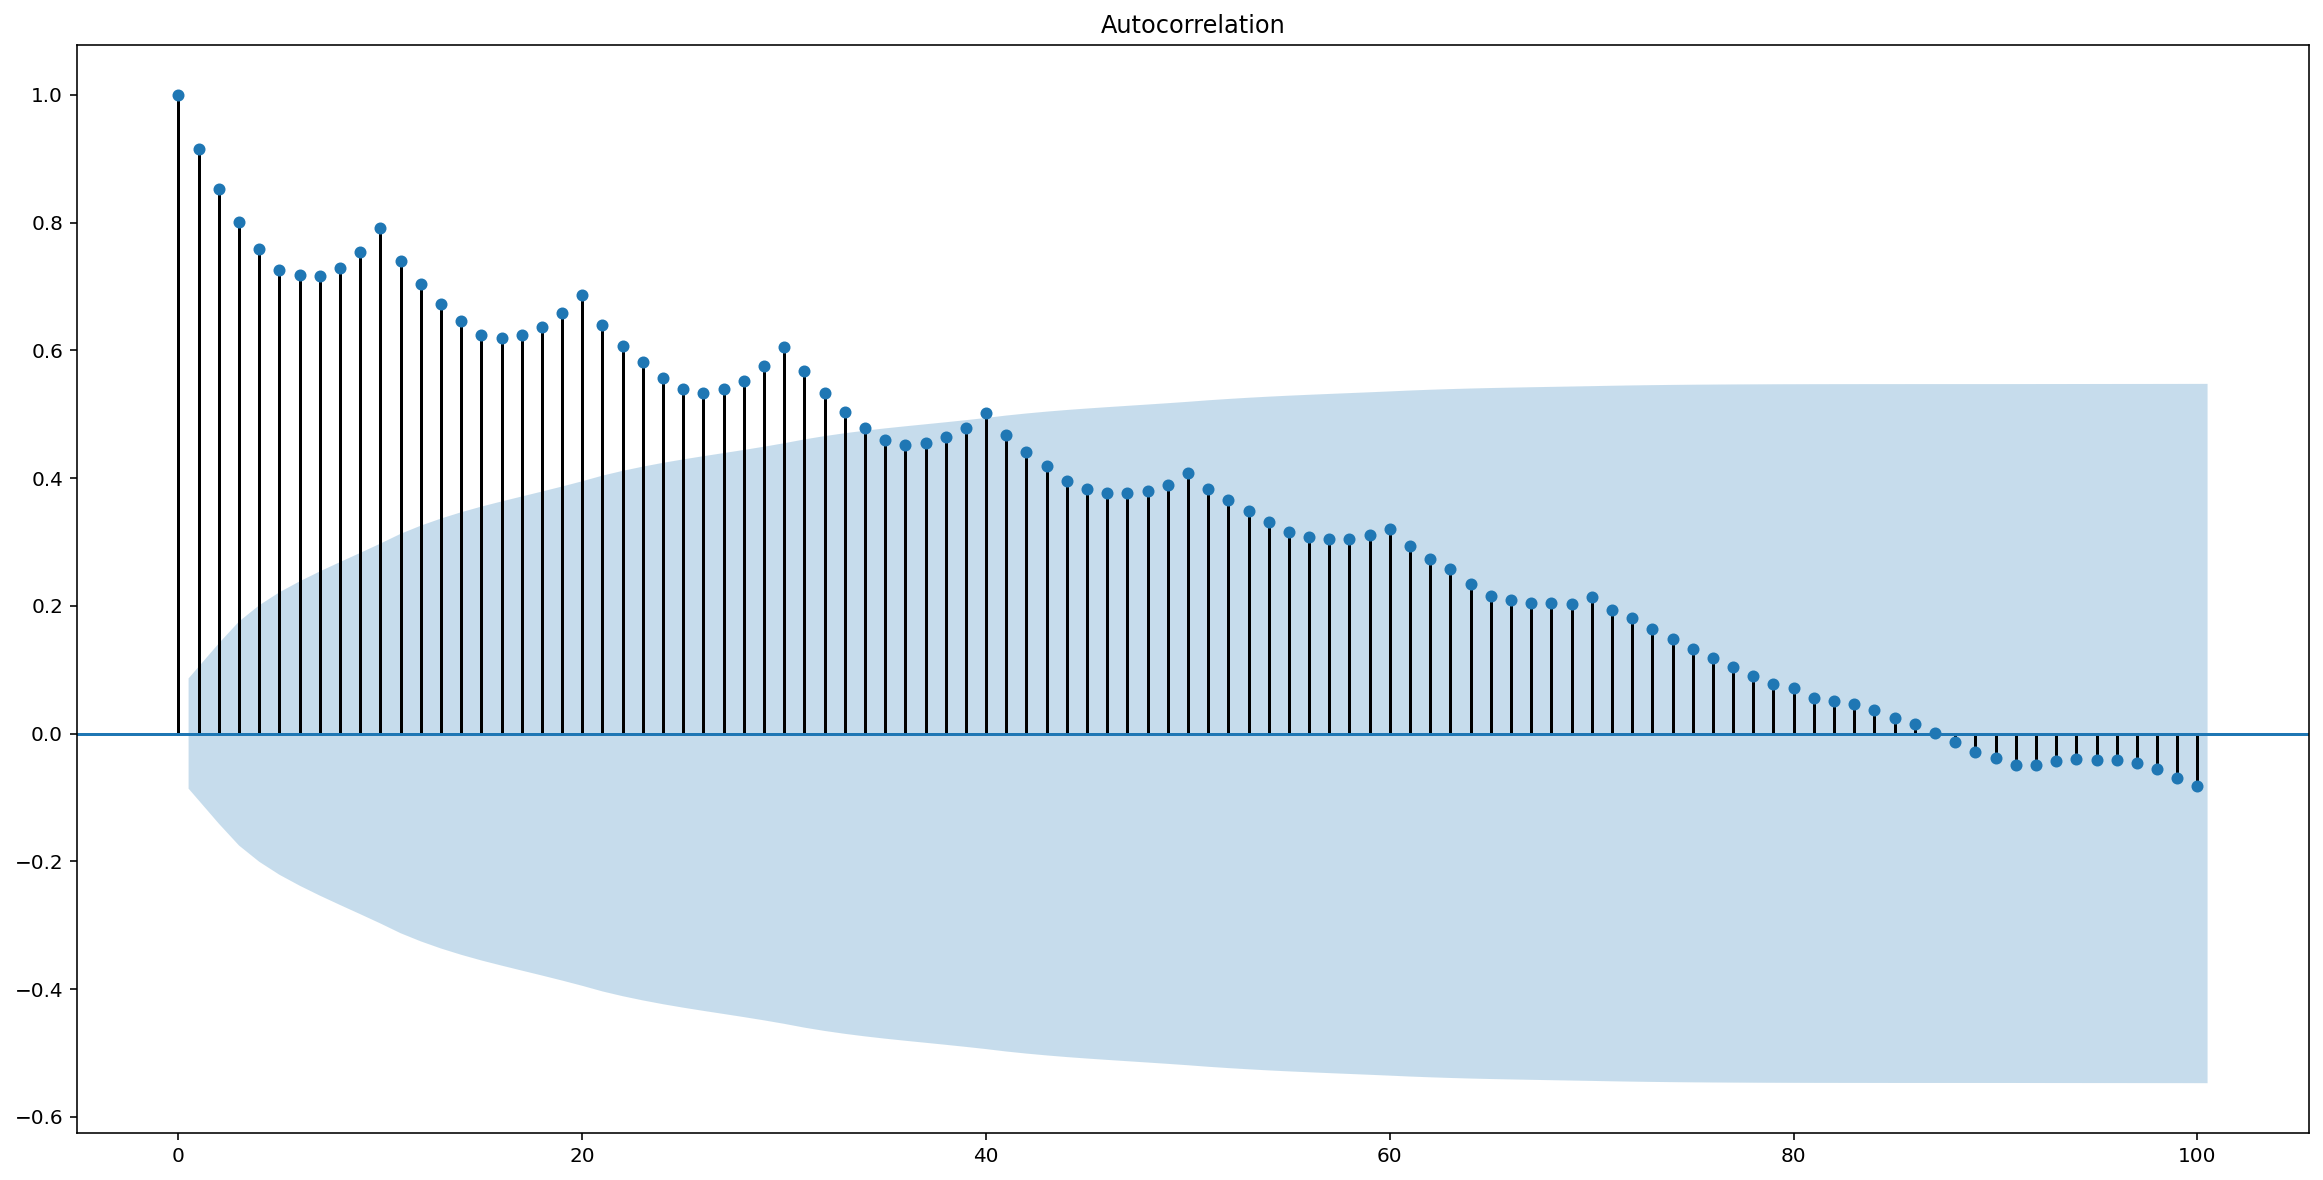

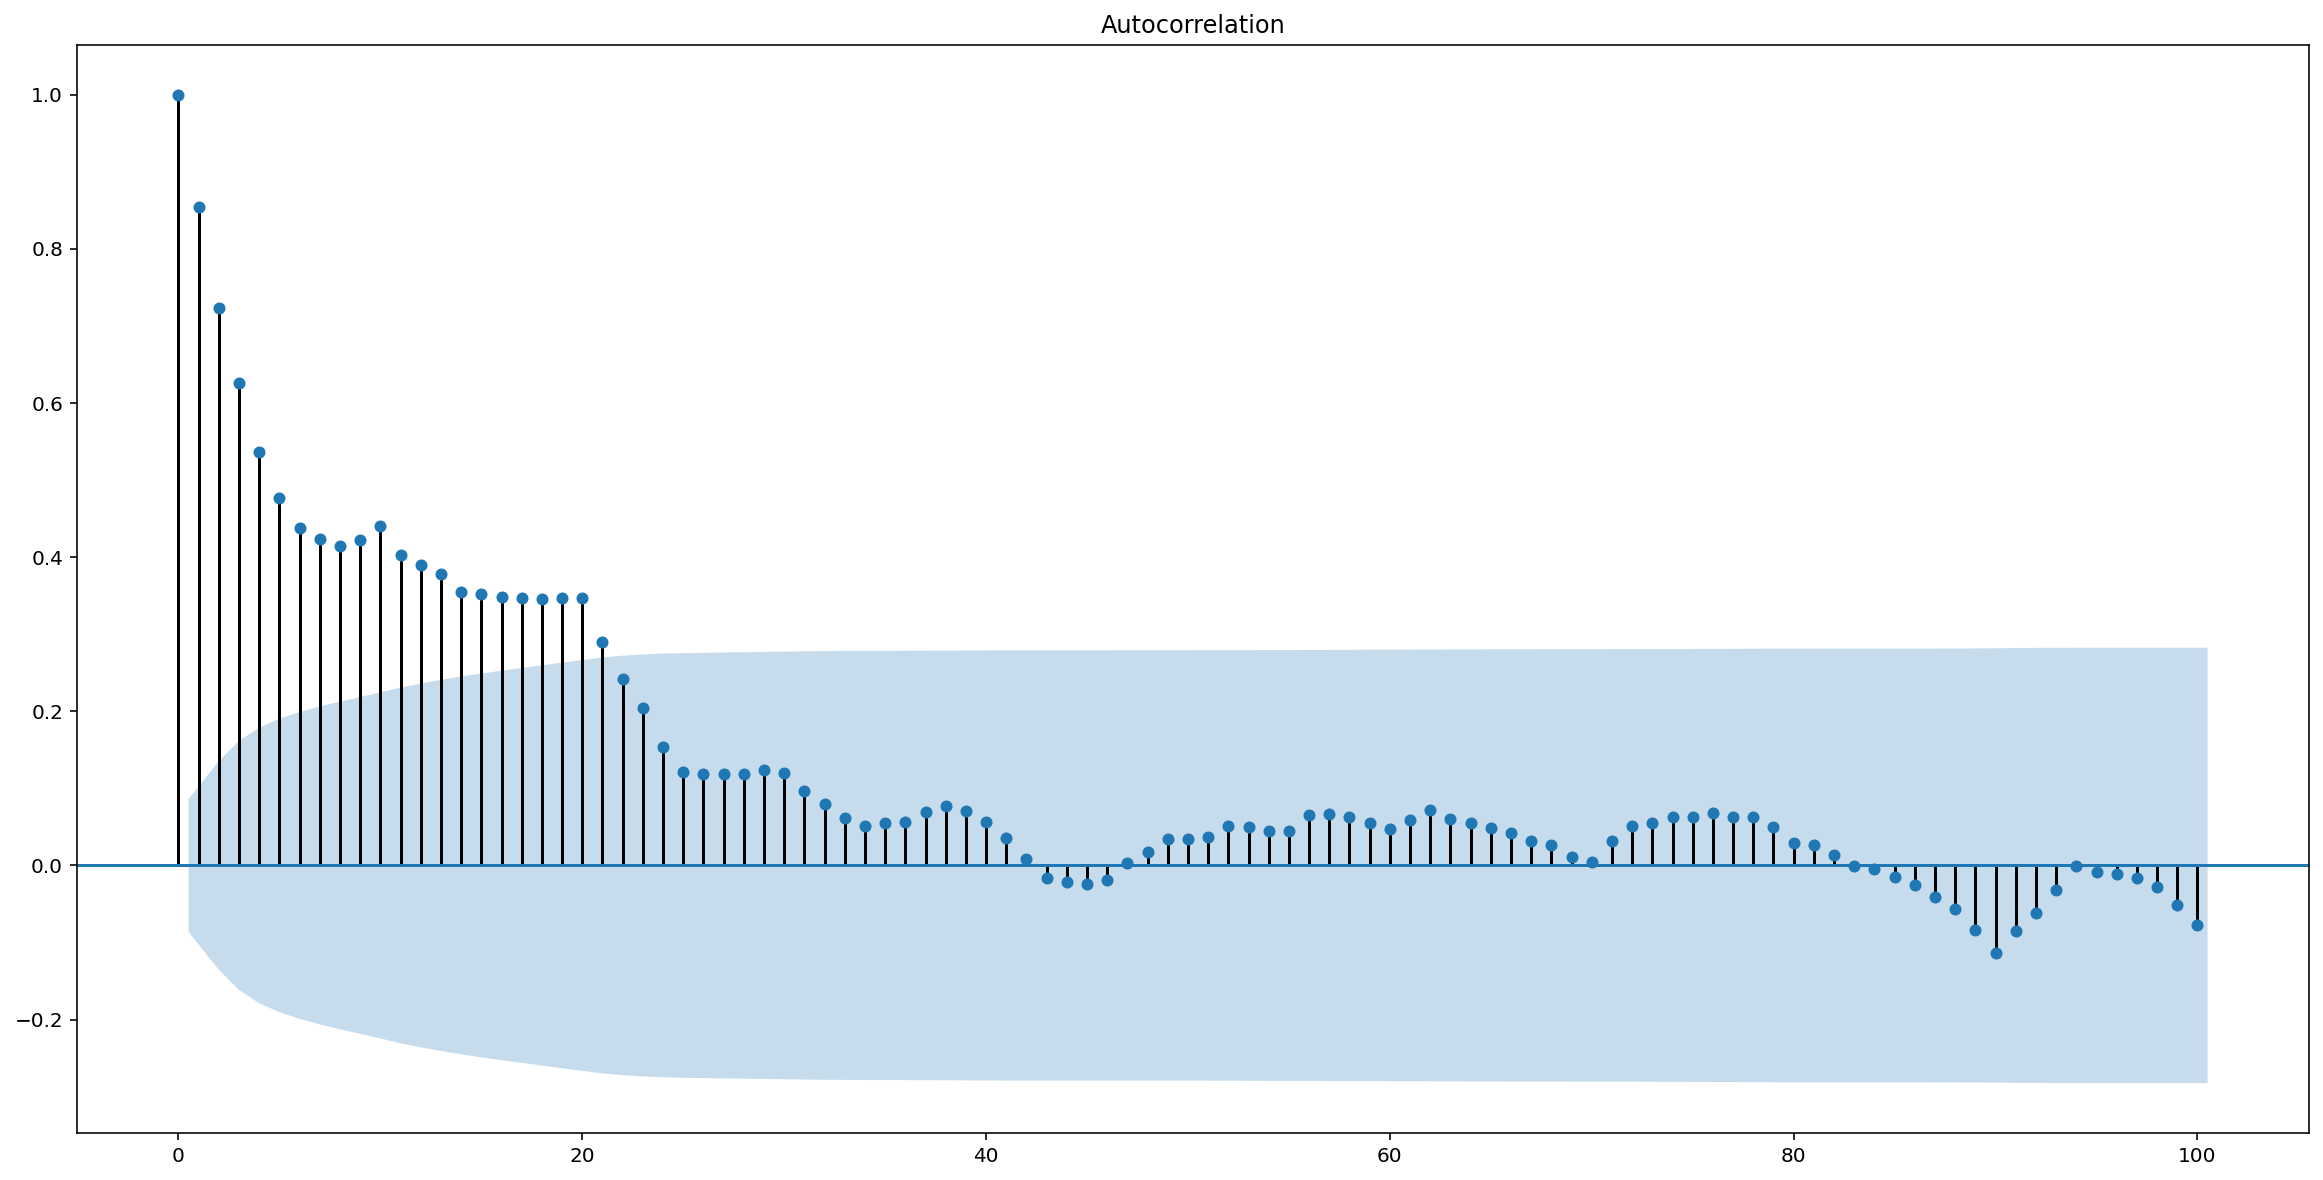

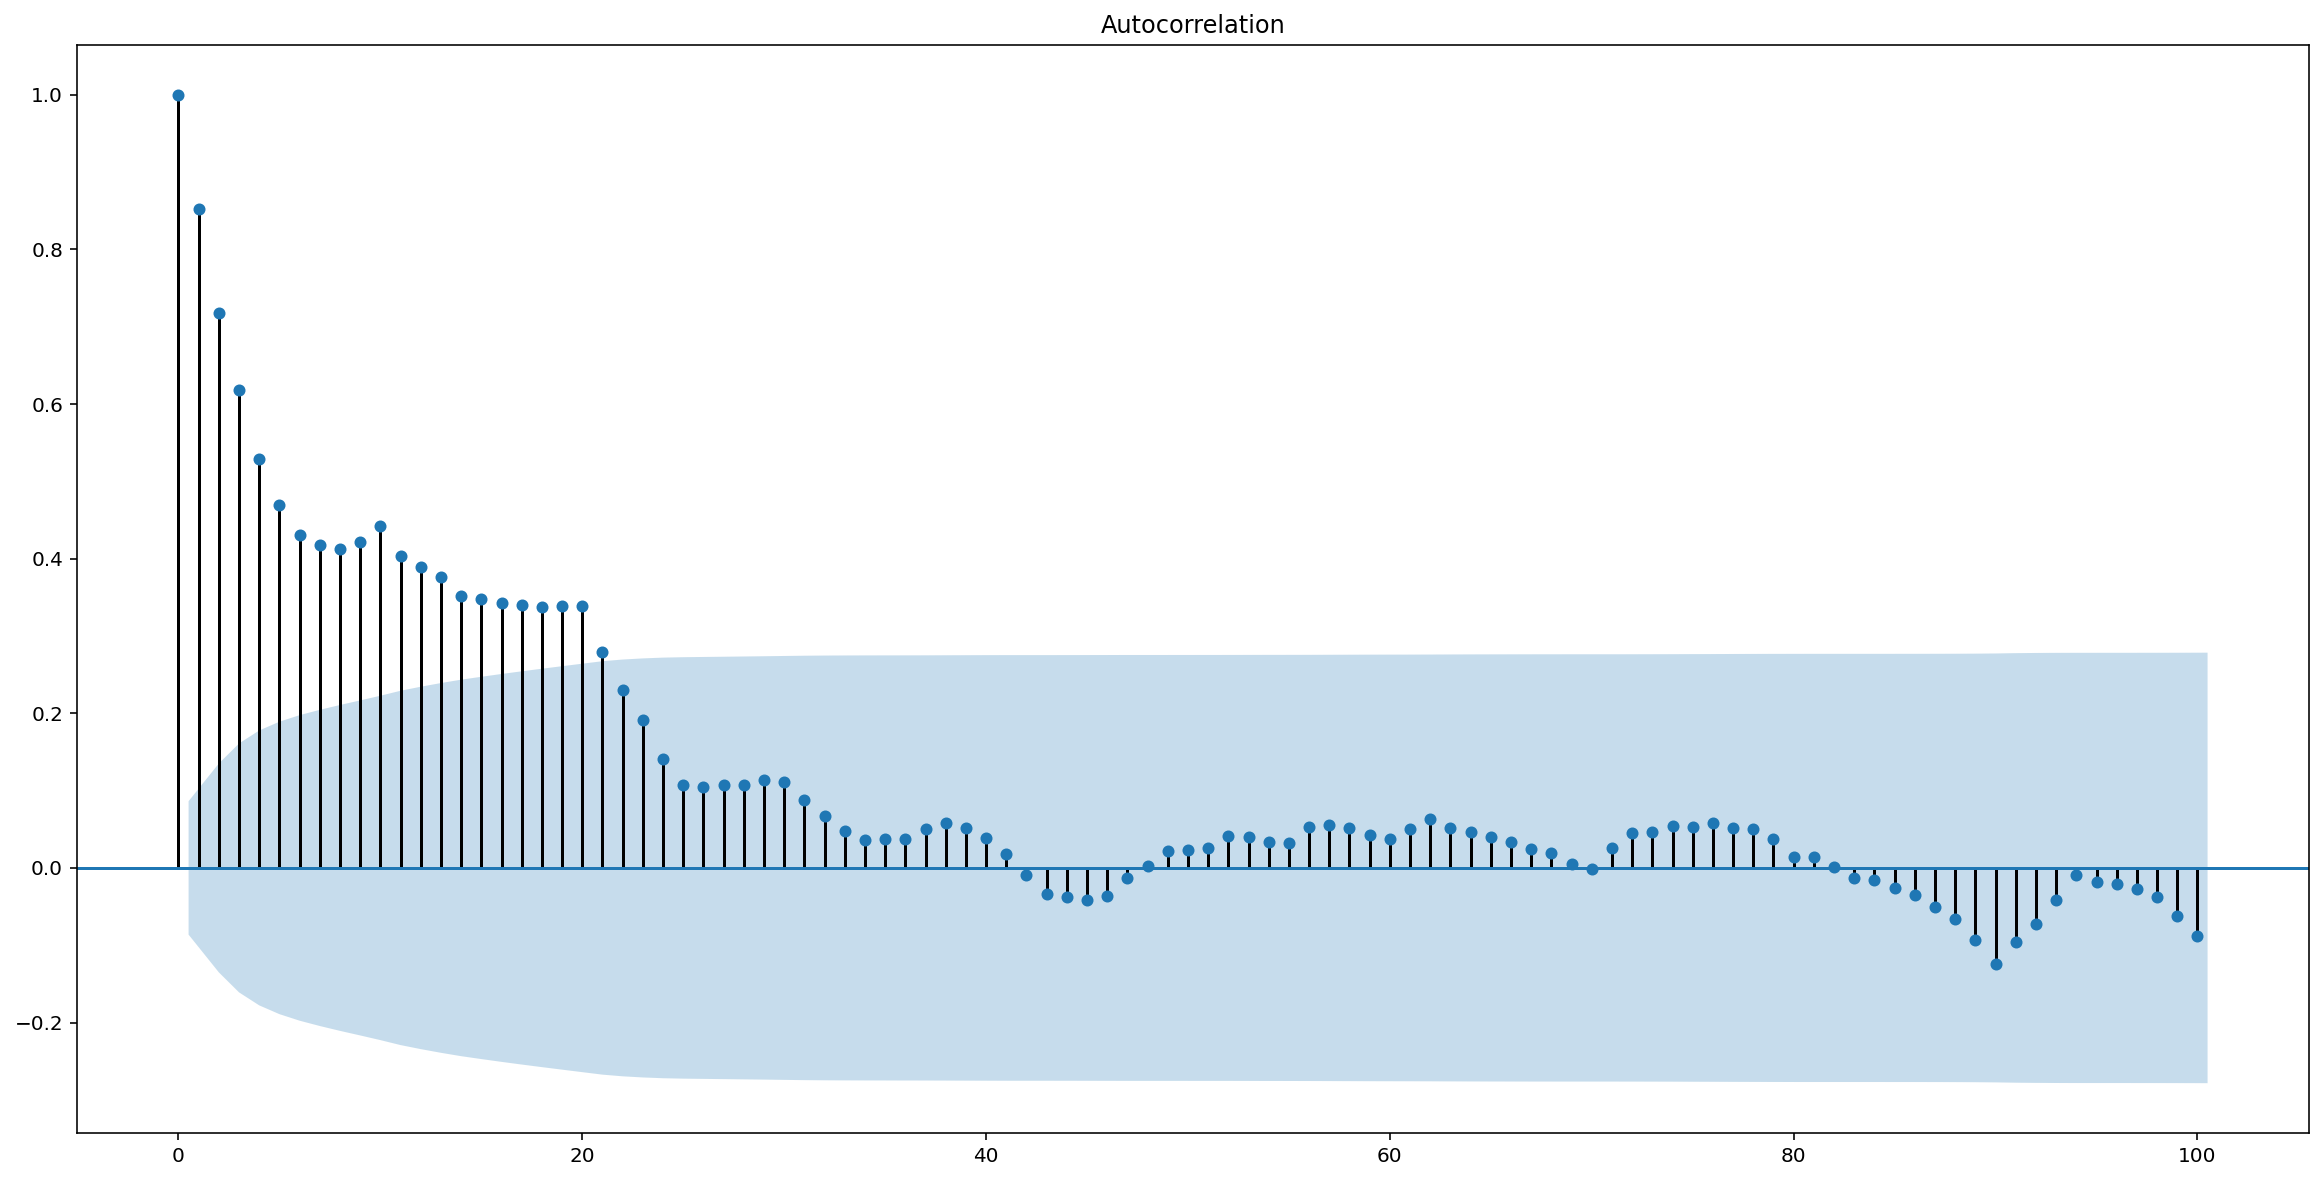

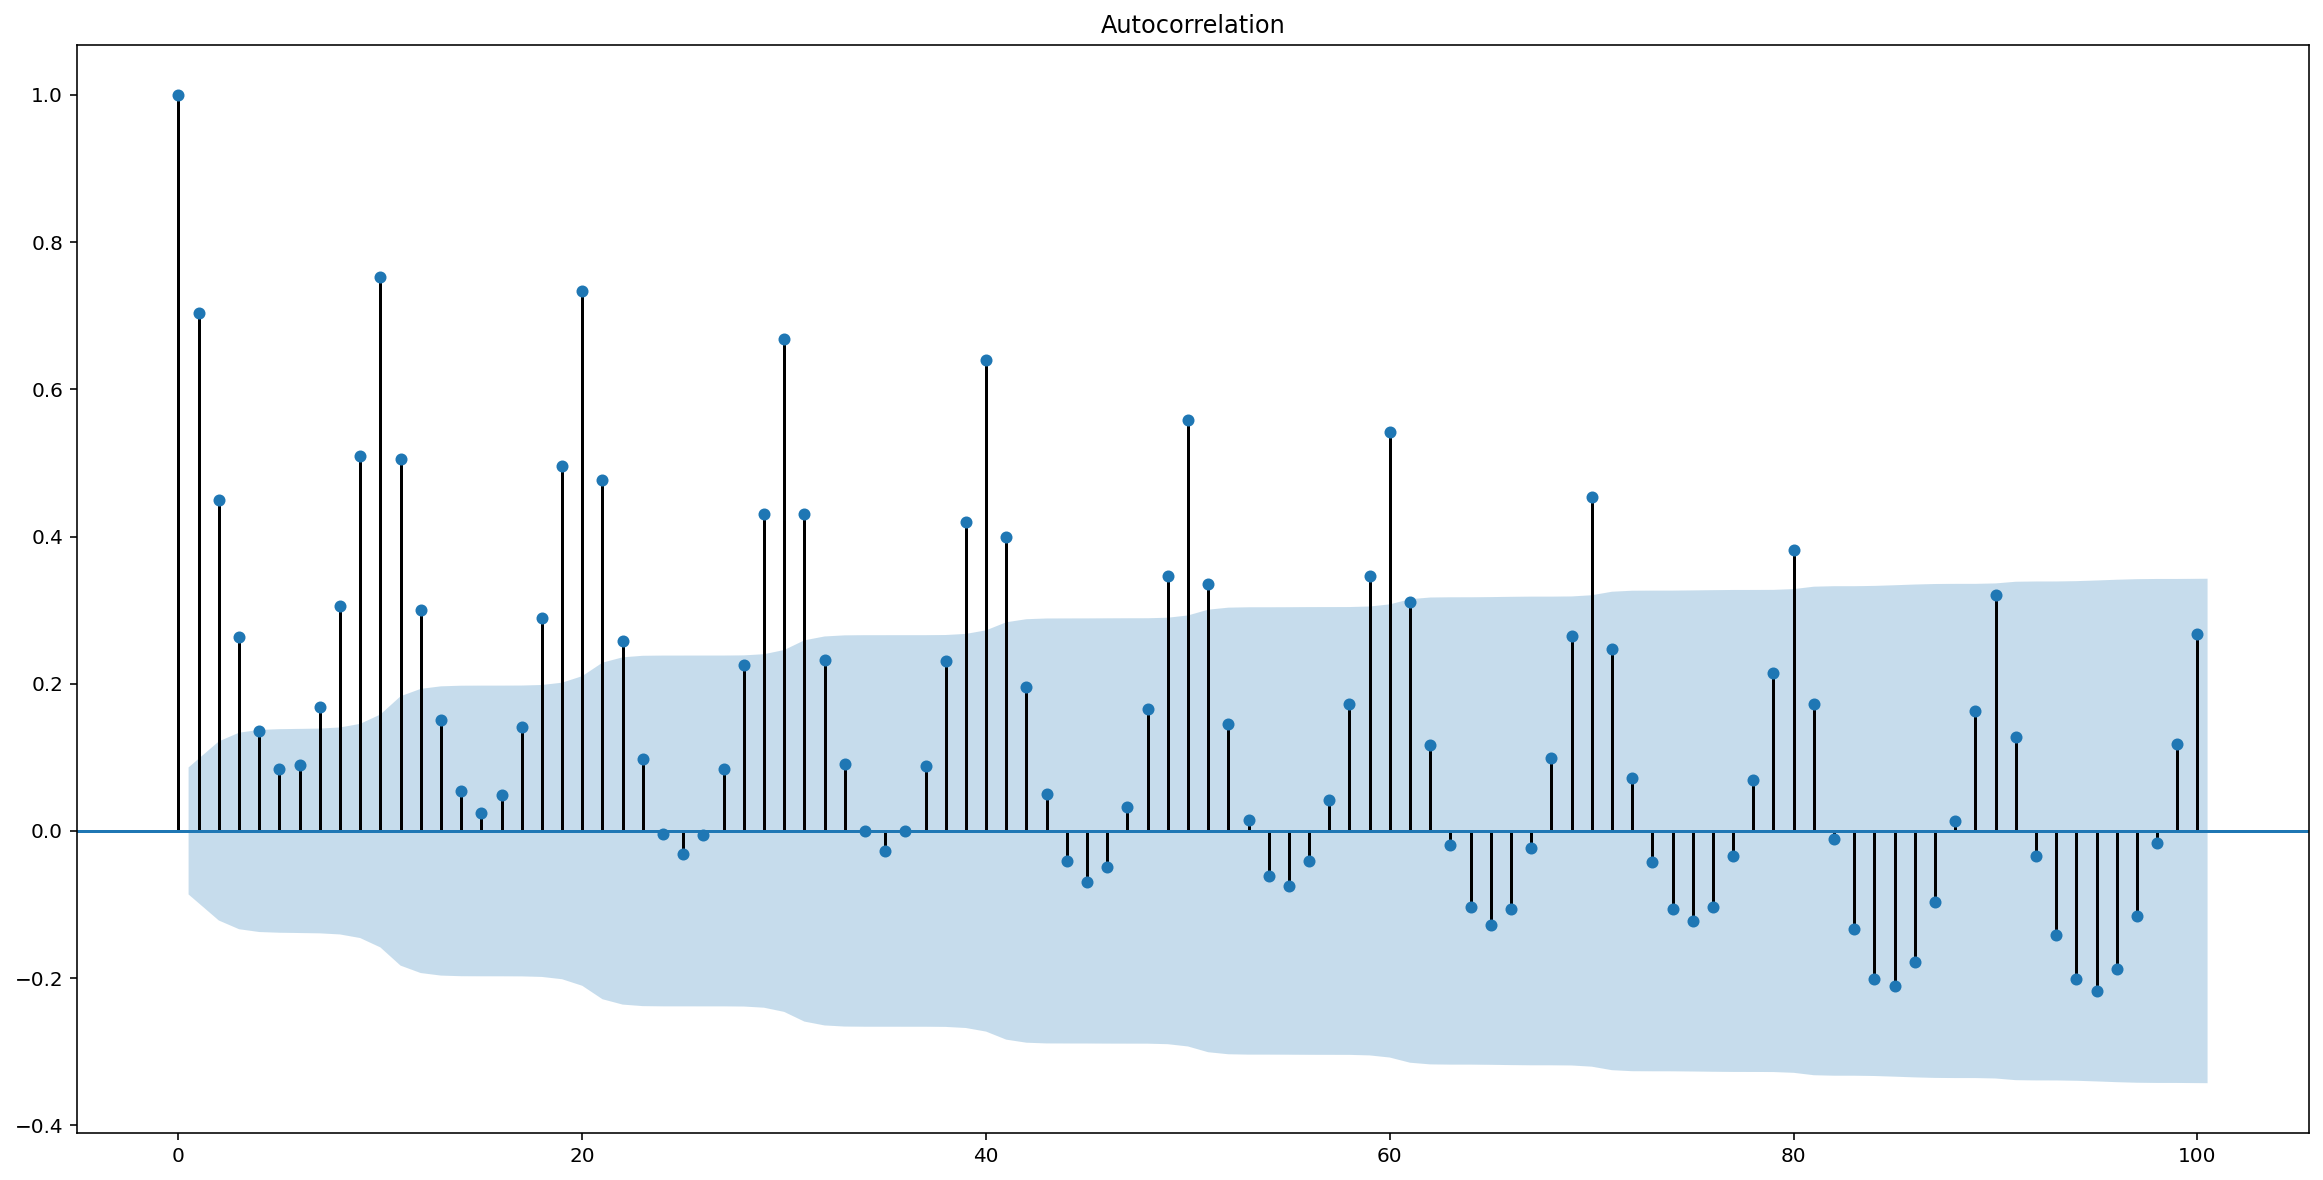

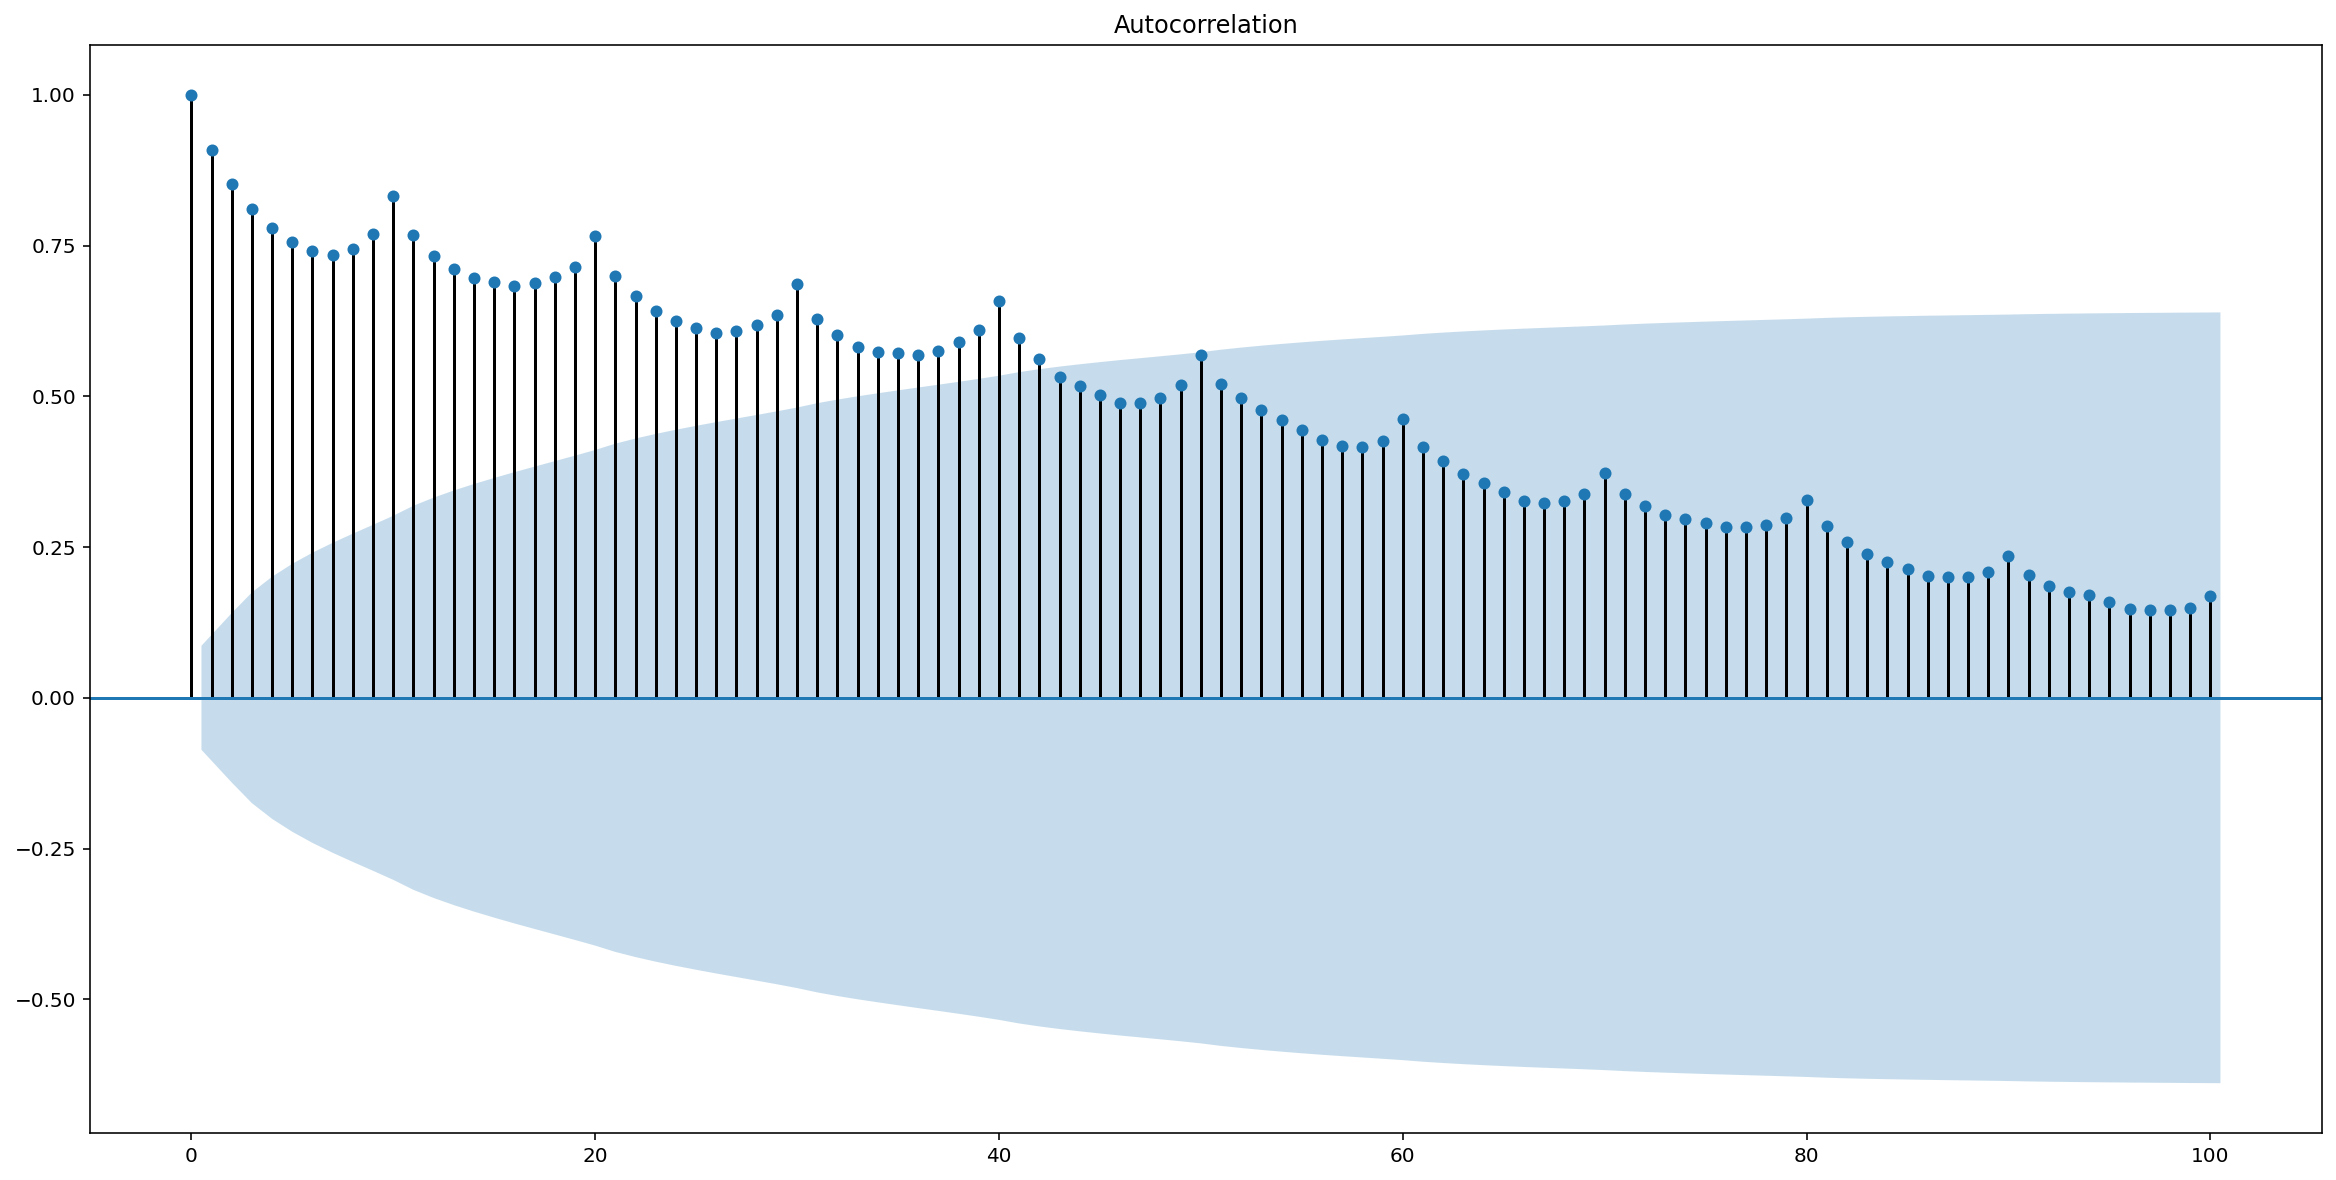

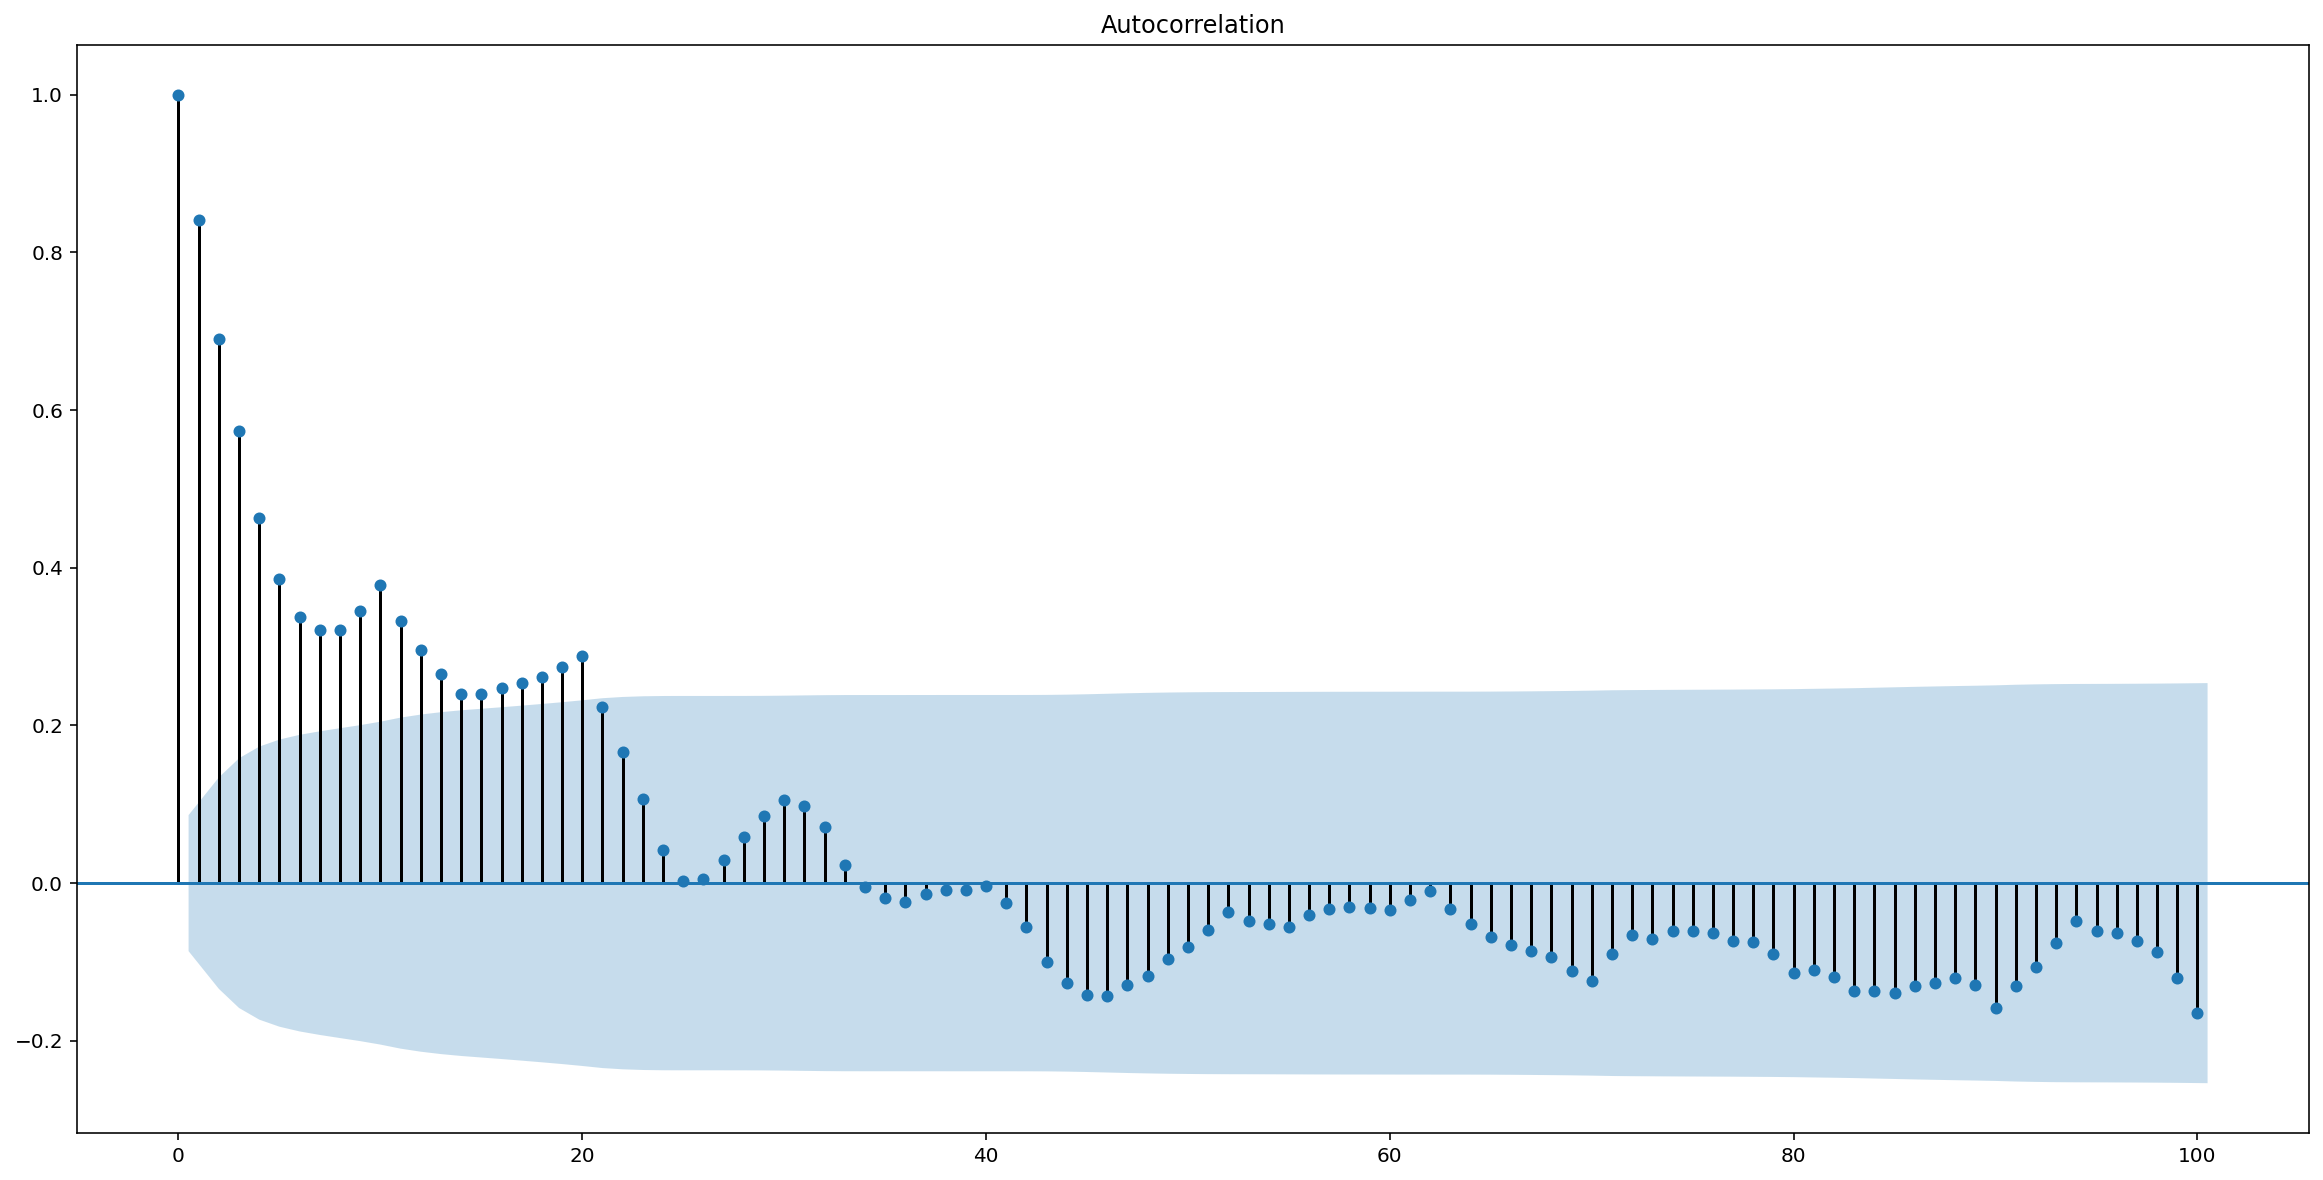

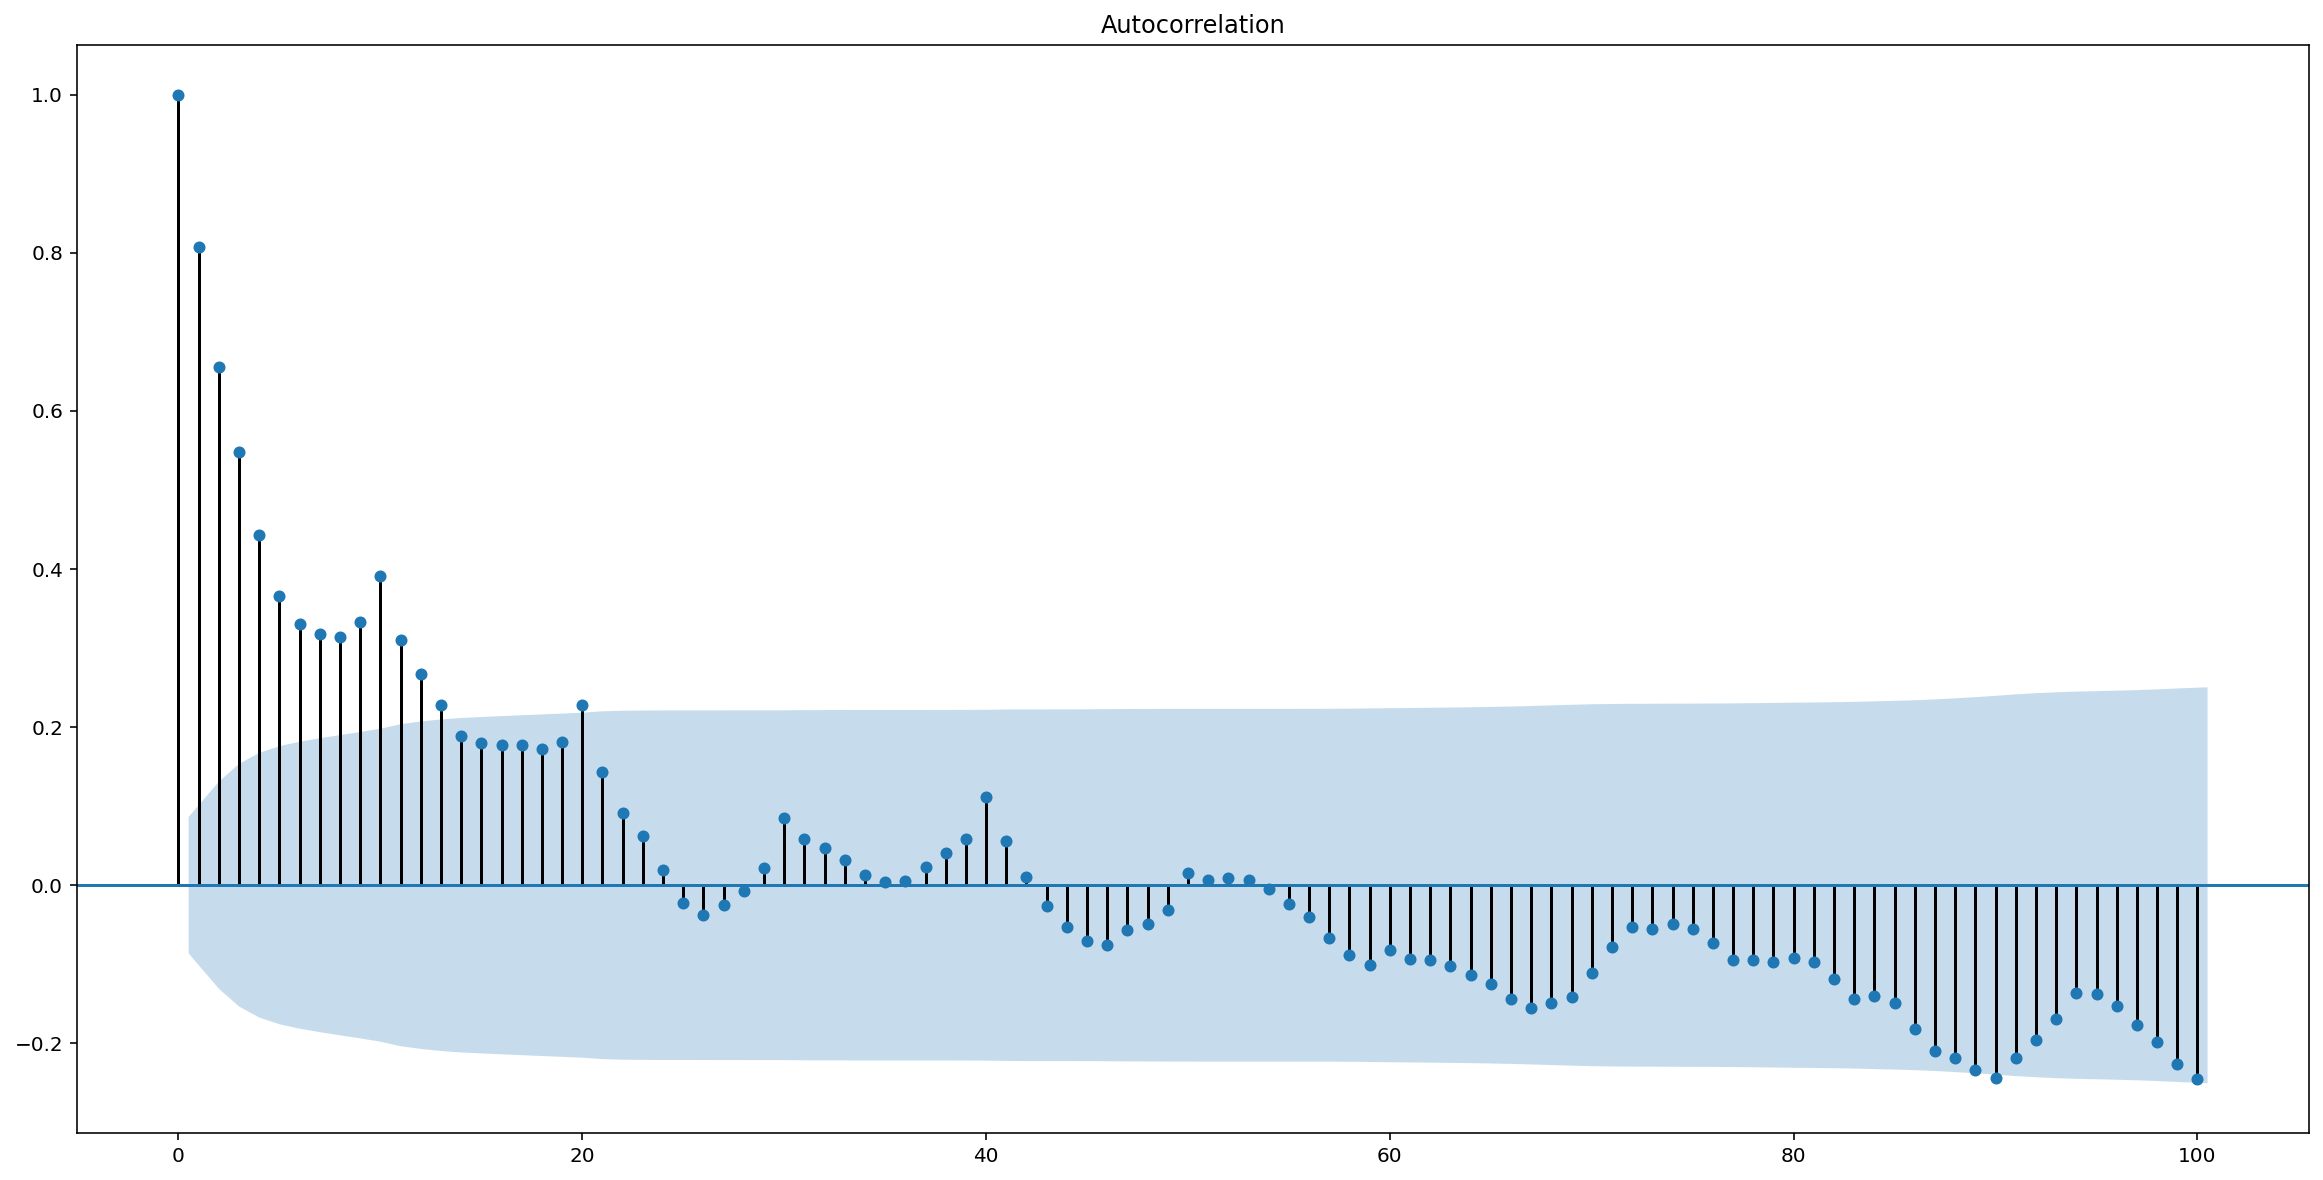

In [0]:
for i in range(n_features):
    fig, ax = plt.subplots(figsize=(20,10))
    plot_acf(y_pred[:,i] - y_hat[:, i], lags=100, ax = ax)

In [25]:
!pip install ml_metrics

  Created wheel for ml-metrics: filename=ml_metrics-0.1.4-cp36-none-any.whl size=7850 sha256=407c4bfba02ab6815aa5bace3f87b0c4234dcf6c6329ba42ec7e341c4c37ce7e
  Stored in directory: /root/.cache/pip/wheels/b3/61/2d/776be7b8a4f14c5db48c8e5451451cabc58dc6aa7ee3801163
Successfully built ml-metrics


In [0]:
import ml_metrics as metrics

In [0]:
metrics.rmse(y_hat[:, -2], y_pred[:, -2])

In [0]:
metrics.mae(y_hat[:, -2], y_pred[:, -2])

In [35]:
metrics.rmse(y_hat, y_pred)

0.014295948

In [36]:
metrics.mae(y_hat, y_pred)

0.0074060047

RMSE:

In [0]:
np.square(y_hat - y_pred).mean(axis = 0)

array([2.6763362e-05, 4.4338281e-05, 3.7308026e-05, 5.1861963e-07,
       7.0909920e-07, 3.9048100e-05, 7.4270276e-05, 1.5344673e-08,
       3.7984464e-09, 8.2331070e-10, 6.6702086e-07, 1.0445359e-04,
       2.6251678e-06, 1.9210002e-08, 7.1927832e-07], dtype=float32)